### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import time
import math
from collections import deque
import collections
import pickle
import os
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
#Defining a function to save the Q-dictionary as a pickle file
# This was not used. We used rewards per episode to track the convergence
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        # action size/space is 21 ( includes (0,0) )
        self.state_size = state_size
        self.action_size = action_size

        #hyper parameters for the DQN
        self.discount_factor = 0.75
        self.learning_rate = 0.01      
        self.epsilon = 1
        self.epsilon_decay = 0.99 
        self.epsilon_min = 0.01
        self.batch_size = 100        
        # replay memory using deque
        self.memory = deque(maxlen=2000)

        # main model
        self.model = self.build_model()


    # building the model
    def build_model(self):
        model = Sequential()
        
        # input share is 36 as the state is encoded with the size 5(locations)+24(time hours)+7(week days)       
        input_shape = 36
        model.add(Dense(32, input_dim=input_shape, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions which is 21
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        model.summary
        
        return model



    def get_action(self, state):
        
        # returns the possible requests given the current state
        # Each location has a different propensity to generate requests for rides
        possible_actions_idx,actions = env.requests(state)
        
        # Exploration
        if np.random.rand() <= self.epsilon:
            
            return random.sample(actions,1)[0]

        # Exploitation - Greedy Approach    
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state_encod = env.state_encod_arch2(state)
            state_encod = state_encod.reshape(1, self.state_size)
            
            q_value = self.model.predict(state_encod)
            
            # at each location, not all actions are available
            # we need to select the best action from the possible set of actions/requests
            q_value_values = q_value[0]
            
            listt_q_values = []
            
            q_value_v2 = []
            
            # selecting q values of the actions which were there in possible_actions_idx
            listt_q_values = [value for idx,value in enumerate(q_value_values) if idx in possible_actions_idx]
                        
            q_value_v2.append(listt_q_values)
            
            return actions[np.argmax(q_value_v2[0])]
    

    def append_sample(self, state, action, reward, next_state):
        
        self.memory.append((state, action, reward, next_state))
    

    # picking samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                state_encod = env.state_encod_arch2(state)
                next_state_encod = env.state_encod_arch2(next_state)           
                
                
                # Updating the 'update_output' and 'update_input' batch and storing actions and rewards
                update_input[i] = state_encod
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state_encod

            
            # predicting the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.model.predict(update_output)
                                    
            # update the target values
            for i in range(self.batch_size):
                
                target[i][env.action_space.index(actions[i])] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                                
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    # saving model weights
    def save(self, name):
        self.model.save_weights(name)
        
    # saving model architecture    
    def save_model_arch(self):
        model_json = self.model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)

In [5]:
Episodes = 7000

### DQN block

In [6]:
# Call the environment
# Call all the initialised variables of the environment
# state size and action size
state_size = 36
action_size = 21

# Calling the env
env = CabDriver()

# Initialising the agent class
dqn_agent = DQNAgent(state_size=state_size,action_size=action_size)

rewards_per_episode, episodes = [], []

if not os.path.exists("saved_model_weights"):
    os.mkdir("saved_model_weights")

for episode in range(Episodes):
    
    # to track the processing time taken per episode 
    start_time = time.time()
    
    # to track rewards per episode
    score = 0
    
    _,_,state = env.reset()
    
    # each episode is assumed to consists of ride hours per month(30 days)
    total_hours_per_episode = 24*30
    
    total_time_taken = 0
    
    terminal_state = False
    
    while not terminal_state:
        
        action = dqn_agent.get_action(state)
        
        next_state = env.next_state_func(state, action, Time_matrix)
        
        reward = env.reward_func(state, action, Time_matrix)
                  
        dqn_agent.append_sample(state, action, reward, next_state)

        dqn_agent.train_model()
        
        score += reward
        
        state = next_state
        
        if action==(0,0):
            
            total_time_taken += 1
        
        else:
            # our state_space is encoded from 1 to 5 while the Time_matrix works on states encoded 0 to 4
            time_taken_curr_to_pickup = Time_matrix[ state[0] - 1 ][ action[0] - 1 ][ state[1] ][ state[2] ]
            
            # if time exceeds 23 hours, make necessary changes
            if state[1] + time_taken_curr_to_pickup > 23:
                time_taken_pickup_to_drop = Time_matrix[ action[0] - 1 ][ action[1] - 1 ][ state[1] + int(time_taken_curr_to_pickup) - 24 ][ (state[2]+1)%7 ]

            else:
                time_taken_pickup_to_drop = Time_matrix[ action[0] - 1 ][ action[1] - 1 ][ state[1] + int(time_taken_curr_to_pickup) ][ state[2] ]
            
            total_time = time_taken_curr_to_pickup + time_taken_pickup_to_drop
            
            total_time_taken += total_time
        
        if total_time_taken>=total_hours_per_episode:
            terminal_state=True
        
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # updating the value of epsilon after each episode
    if dqn_agent.epsilon > dqn_agent.epsilon_min:
        # the curve for this function is given below
        dqn_agent.epsilon = (1 - 0) * np.exp(-0.0005*episode)
        
    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(dqn_agent.memory),
                                                                         dqn_agent.epsilon))
    end_time = time.time()
    print("travel time-",total_time_taken)
    print("--- %s seconds ---" % (end_time - start_time))
    
    # storing model_weights after every 10 episodes
    # was commented out and only the final model weights were saved
    if episode % 10 == 0:
        
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        model_name = "model_weights"+"_"+str(episode)+".h5"
        #dqn_agent.save(name=model_name)
        

episode 0, reward 65.0, memory_length 160, epsilon 1.0
travel time- 723.0
--- 19.67903995513916 seconds ---
episode 1, reward -358.0, memory_length 332, epsilon 0.9995001249791693
travel time- 724.0
--- 2.3255536556243896 seconds ---
episode 2, reward -23.0, memory_length 499, epsilon 0.999000499833375
travel time- 721.0
--- 2.2163305282592773 seconds ---
episode 3, reward -79.0, memory_length 660, epsilon 0.9985011244377109
travel time- 720.0
--- 2.136045217514038 seconds ---
episode 4, reward -10.0, memory_length 819, epsilon 0.9980019986673331
travel time- 730.0
--- 2.159180164337158 seconds ---
episode 5, reward -81.0, memory_length 989, epsilon 0.9975031223974601
travel time- 720.0
--- 2.1930692195892334 seconds ---
episode 6, reward 184.0, memory_length 1126, epsilon 0.997004495503373
travel time- 723.0
--- 1.7810935974121094 seconds ---
episode 7, reward -216.0, memory_length 1268, epsilon 0.9965061178604149
travel time- 721.0
--- 1.8709735870361328 seconds ---
episode 8, reward

episode 65, reward -248.0, memory_length 2000, epsilon 0.968022449831306
travel time- 730.0
--- 1.9400184154510498 seconds ---
episode 66, reward -251.0, memory_length 2000, epsilon 0.967538559589032
travel time- 729.0
--- 2.0181217193603516 seconds ---
episode 67, reward -162.0, memory_length 2000, epsilon 0.9670549112314029
travel time- 720.0
--- 2.0555944442749023 seconds ---
episode 68, reward -383.0, memory_length 2000, epsilon 0.9665715046375066
travel time- 726.0
--- 1.9575493335723877 seconds ---
episode 69, reward -332.0, memory_length 2000, epsilon 0.9660883396864915
travel time- 734.0
--- 1.7753186225891113 seconds ---
episode 70, reward -299.0, memory_length 2000, epsilon 0.9656054162575665
travel time- 725.0
--- 2.29790997505188 seconds ---
episode 71, reward -672.0, memory_length 2000, epsilon 0.9651227342300005
travel time- 723.0
--- 2.1055657863616943 seconds ---
episode 72, reward -119.0, memory_length 2000, epsilon 0.9646402934831231
travel time- 720.0
--- 2.092662096

episode 130, reward -338.0, memory_length 2000, epsilon 0.9370674633774034
travel time- 728.0
--- 1.9576265811920166 seconds ---
episode 131, reward 110.0, memory_length 2000, epsilon 0.9365990467596279
travel time- 722.0
--- 1.7379388809204102 seconds ---
episode 132, reward -180.0, memory_length 2000, epsilon 0.9361308642916188
travel time- 729.0
--- 1.7344415187835693 seconds ---
episode 133, reward -233.0, memory_length 2000, epsilon 0.9356629158563308
travel time- 720.0
--- 2.045578718185425 seconds ---
episode 134, reward -148.0, memory_length 2000, epsilon 0.9351952013367766
travel time- 724.0
--- 2.048966407775879 seconds ---
episode 135, reward -153.0, memory_length 2000, epsilon 0.9347277206160275
travel time- 728.0
--- 2.1784989833831787 seconds ---
episode 136, reward -521.0, memory_length 2000, epsilon 0.9342604735772135
travel time- 721.0
--- 2.1467254161834717 seconds ---
episode 137, reward -114.0, memory_length 2000, epsilon 0.9337934601035228
travel time- 723.0
--- 2.

episode 195, reward -109.0, memory_length 2000, epsilon 0.9071023415558017
travel time- 733.0
--- 2.226339340209961 seconds ---
episode 196, reward -10.0, memory_length 2000, epsilon 0.9066489037539209
travel time- 722.0
--- 2.3375792503356934 seconds ---
episode 197, reward -43.0, memory_length 2000, epsilon 0.9061956926142708
travel time- 720.0
--- 2.062601089477539 seconds ---
episode 198, reward 24.0, memory_length 2000, epsilon 0.9057427080235485
travel time- 729.0
--- 2.0547034740448 seconds ---
episode 199, reward -209.0, memory_length 2000, epsilon 0.905289949868508
travel time- 724.0
--- 2.063581943511963 seconds ---
episode 200, reward 157.0, memory_length 2000, epsilon 0.9048374180359595
travel time- 727.0
--- 1.8661773204803467 seconds ---
episode 201, reward -319.0, memory_length 2000, epsilon 0.9043851124127704
travel time- 729.0
--- 2.2815983295440674 seconds ---
episode 202, reward -370.0, memory_length 2000, epsilon 0.9039330328858641
travel time- 724.0
--- 2.192746400

episode 260, reward -387.0, memory_length 2000, epsilon 0.8780954309205613
travel time- 723.0
--- 3.412121534347534 seconds ---
episode 261, reward -272.0, memory_length 2000, epsilon 0.8776564929487385
travel time- 726.0
--- 2.808091163635254 seconds ---
episode 262, reward -291.0, memory_length 2000, epsilon 0.8772177743910435
travel time- 723.0
--- 2.123446226119995 seconds ---
episode 263, reward 67.0, memory_length 2000, epsilon 0.8767792751377967
travel time- 722.0
--- 2.2159030437469482 seconds ---
episode 264, reward -276.0, memory_length 2000, epsilon 0.8763409950793732
travel time- 723.0
--- 1.8900442123413086 seconds ---
episode 265, reward 15.0, memory_length 2000, epsilon 0.8759029341062031
travel time- 728.0
--- 2.0287044048309326 seconds ---
episode 266, reward -432.0, memory_length 2000, epsilon 0.8754650921087711
travel time- 722.0
--- 1.9037692546844482 seconds ---
episode 267, reward -58.0, memory_length 2000, epsilon 0.8750274689776166
travel time- 720.0
--- 1.87359

episode 324, reward -373.0, memory_length 2000, epsilon 0.850441204540233
travel time- 720.0
--- 1.871164321899414 seconds ---
episode 325, reward -110.0, memory_length 2000, epsilon 0.8500160902253981
travel time- 725.0
--- 1.7193336486816406 seconds ---
episode 326, reward -604.0, memory_length 2000, epsilon 0.8495911884145902
travel time- 721.0
--- 1.961475133895874 seconds ---
episode 327, reward -245.0, memory_length 2000, epsilon 0.8491664990015839
travel time- 724.0
--- 1.7795124053955078 seconds ---
episode 328, reward -299.0, memory_length 2000, epsilon 0.8487420218802068
travel time- 721.0
--- 1.9543447494506836 seconds ---
episode 329, reward 124.0, memory_length 2000, epsilon 0.8483177569443394
travel time- 724.0
--- 1.7125940322875977 seconds ---
episode 330, reward -354.0, memory_length 2000, epsilon 0.8478937040879159
travel time- 722.0
--- 1.7982335090637207 seconds ---
episode 331, reward -374.0, memory_length 2000, epsilon 0.8474698632049227
travel time- 720.0
--- 1.6

episode 388, reward -390.0, memory_length 2000, epsilon 0.8236579042685769
travel time- 726.0
--- 2.074744701385498 seconds ---
episode 389, reward 126.0, memory_length 2000, epsilon 0.8232461782565231
travel time- 724.0
--- 1.6016285419464111 seconds ---
episode 390, reward -80.0, memory_length 2000, epsilon 0.8228346580560184
travel time- 722.0
--- 1.8259944915771484 seconds ---
episode 391, reward 91.0, memory_length 2000, epsilon 0.8224233435641823
travel time- 723.0
--- 1.6348528861999512 seconds ---
episode 392, reward -185.0, memory_length 2000, epsilon 0.8220122346781865
travel time- 720.0
--- 1.8576135635375977 seconds ---
episode 393, reward -458.0, memory_length 2000, epsilon 0.8216013312952537
travel time- 724.0
--- 1.880922555923462 seconds ---
episode 394, reward -199.0, memory_length 2000, epsilon 0.821190633312658
travel time- 724.0
--- 1.6323535442352295 seconds ---
episode 395, reward 82.0, memory_length 2000, epsilon 0.8207801406277248
travel time- 726.0
--- 1.751409

episode 452, reward -136.0, memory_length 2000, epsilon 0.7977181016656743
travel time- 726.0
--- 1.8544740676879883 seconds ---
episode 453, reward -302.0, memory_length 2000, epsilon 0.7973193423129871
travel time- 725.0
--- 1.8747327327728271 seconds ---
episode 454, reward 10.0, memory_length 2000, epsilon 0.7969207822901396
travel time- 729.0
--- 1.7242748737335205 seconds ---
episode 455, reward -8.0, memory_length 2000, epsilon 0.7965224214974919
travel time- 721.0
--- 1.7485551834106445 seconds ---
episode 456, reward 159.0, memory_length 2000, epsilon 0.7961242598354538
travel time- 725.0
--- 2.012632131576538 seconds ---
episode 457, reward -152.0, memory_length 2000, epsilon 0.7957262972044846
travel time- 722.0
--- 1.9300141334533691 seconds ---
episode 458, reward -163.0, memory_length 2000, epsilon 0.7953285335050939
travel time- 720.0
--- 1.8360304832458496 seconds ---
episode 459, reward -161.0, memory_length 2000, epsilon 0.7949309686378409
travel time- 726.0
--- 1.867

episode 516, reward -373.0, memory_length 2000, epsilon 0.772595232106928
travel time- 725.0
--- 1.745253324508667 seconds ---
episode 517, reward -12.0, memory_length 2000, epsilon 0.7722090310491848
travel time- 723.0
--- 1.4550666809082031 seconds ---
episode 518, reward -249.0, memory_length 2000, epsilon 0.7718230230437034
travel time- 721.0
--- 1.7949731349945068 seconds ---
episode 519, reward -205.0, memory_length 2000, epsilon 0.7714372079939819
travel time- 723.0
--- 1.943981647491455 seconds ---
episode 520, reward -186.0, memory_length 2000, epsilon 0.7710515858035663
travel time- 725.0
--- 1.654547929763794 seconds ---
episode 521, reward -34.0, memory_length 2000, epsilon 0.7706661563760512
travel time- 724.0
--- 2.0035400390625 seconds ---
episode 522, reward -219.0, memory_length 2000, epsilon 0.7702809196150792
travel time- 722.0
--- 1.6472885608673096 seconds ---
episode 523, reward -554.0, memory_length 2000, epsilon 0.769895875424341
travel time- 727.0
--- 2.0528044

episode 581, reward -71.0, memory_length 2000, epsilon 0.747889529312135
travel time- 727.0
--- 1.8281540870666504 seconds ---
episode 582, reward -369.0, memory_length 2000, epsilon 0.747515678018091
travel time- 722.0
--- 1.838256597518921 seconds ---
episode 583, reward -254.0, memory_length 2000, epsilon 0.7471420136029704
travel time- 720.0
--- 1.792543888092041 seconds ---
episode 584, reward 114.0, memory_length 2000, epsilon 0.7467685359733571
travel time- 724.0
--- 1.5183846950531006 seconds ---
episode 585, reward -3.0, memory_length 2000, epsilon 0.7463952450358817
travel time- 723.0
--- 1.7108111381530762 seconds ---
episode 586, reward -460.0, memory_length 2000, epsilon 0.7460221406972215
travel time- 724.0
--- 1.7648072242736816 seconds ---
episode 587, reward -385.0, memory_length 2000, epsilon 0.7456492228641003
travel time- 722.0
--- 1.706486701965332 seconds ---
episode 588, reward -138.0, memory_length 2000, epsilon 0.7452764914432887
travel time- 720.0
--- 1.752703

episode 645, reward -405.0, memory_length 2000, epsilon 0.7243359318069157
travel time- 720.0
--- 1.9071846008300781 seconds ---
episode 646, reward -194.0, memory_length 2000, epsilon 0.7239738543679153
travel time- 723.0
--- 1.582568645477295 seconds ---
episode 647, reward -41.0, memory_length 2000, epsilon 0.7236119579223822
travel time- 722.0
--- 1.7149617671966553 seconds ---
episode 648, reward 26.0, memory_length 2000, epsilon 0.7232502423798424
travel time- 725.0
--- 2.0488193035125732 seconds ---
episode 649, reward -139.0, memory_length 2000, epsilon 0.722888707649867
travel time- 720.0
--- 1.760023593902588 seconds ---
episode 650, reward 25.0, memory_length 2000, epsilon 0.7225273536420722
travel time- 731.0
--- 1.6149091720581055 seconds ---
episode 651, reward 73.0, memory_length 2000, epsilon 0.7221661802661196
travel time- 722.0
--- 1.3951184749603271 seconds ---
episode 652, reward -115.0, memory_length 2000, epsilon 0.7218051874317158
travel time- 730.0
--- 1.9097962

episode 710, reward -151.0, memory_length 2000, epsilon 0.7011734432085724
travel time- 724.0
--- 1.8793566226959229 seconds ---
episode 711, reward -270.0, memory_length 2000, epsilon 0.7008229441190426
travel time- 726.0
--- 1.6879515647888184 seconds ---
episode 712, reward -237.0, memory_length 2000, epsilon 0.7004726202352524
travel time- 728.0
--- 1.6556668281555176 seconds ---
episode 713, reward -509.0, memory_length 2000, epsilon 0.7001224714696209
travel time- 722.0
--- 1.444382905960083 seconds ---
episode 714, reward -304.0, memory_length 2000, epsilon 0.699772497734611
travel time- 720.0
--- 1.6466569900512695 seconds ---
episode 715, reward -237.0, memory_length 2000, epsilon 0.6994226989427291
travel time- 721.0
--- 1.733656644821167 seconds ---
episode 716, reward -205.0, memory_length 2000, epsilon 0.6990730750065257
travel time- 728.0
--- 1.668463945388794 seconds ---
episode 717, reward -97.0, memory_length 2000, epsilon 0.6987236258385946
travel time- 727.0
--- 1.55

episode 774, reward -86.0, memory_length 2000, epsilon 0.6790910949266368
travel time- 726.0
--- 1.7920432090759277 seconds ---
episode 775, reward -217.0, memory_length 2000, epsilon 0.6787516342514144
travel time- 721.0
--- 1.7799456119537354 seconds ---
episode 776, reward -127.0, memory_length 2000, epsilon 0.678412343264104
travel time- 727.0
--- 1.7335114479064941 seconds ---
episode 777, reward 123.0, memory_length 2000, epsilon 0.6780732218798831
travel time- 728.0
--- 1.7881710529327393 seconds ---
episode 778, reward 32.0, memory_length 2000, epsilon 0.6777342700139711
travel time- 720.0
--- 1.7472543716430664 seconds ---
episode 779, reward -46.0, memory_length 2000, epsilon 0.6773954875816302
travel time- 726.0
--- 1.626112937927246 seconds ---
episode 780, reward -282.0, memory_length 2000, epsilon 0.6770568744981647
travel time- 728.0
--- 1.8730952739715576 seconds ---
episode 781, reward 9.0, memory_length 2000, epsilon 0.6767184306789213
travel time- 725.0
--- 1.4981377

episode 839, reward -80.0, memory_length 2000, epsilon 0.657375425369507
travel time- 721.0
--- 1.6878278255462646 seconds ---
episode 840, reward -488.0, memory_length 2000, epsilon 0.6570468198150567
travel time- 726.0
--- 1.7101709842681885 seconds ---
episode 841, reward 29.0, memory_length 2000, epsilon 0.656718378522315
travel time- 724.0
--- 1.755486011505127 seconds ---
episode 842, reward -268.0, memory_length 2000, epsilon 0.6563901014091712
travel time- 720.0
--- 1.873671054840088 seconds ---
episode 843, reward -48.0, memory_length 2000, epsilon 0.6560619883935562
travel time- 723.0
--- 1.6179776191711426 seconds ---
episode 844, reward -20.0, memory_length 2000, epsilon 0.6557340393934418
travel time- 721.0
--- 1.896219253540039 seconds ---
episode 845, reward -157.0, memory_length 2000, epsilon 0.6554062543268405
travel time- 722.0
--- 1.7986762523651123 seconds ---
episode 846, reward -114.0, memory_length 2000, epsilon 0.6550786331118063
travel time- 727.0
--- 1.6475210

episode 904, reward -236.0, memory_length 2000, epsilon 0.6363541697250871
travel time- 724.0
--- 1.7474868297576904 seconds ---
episode 905, reward -153.0, memory_length 2000, epsilon 0.63603607217124
travel time- 723.0
--- 1.581383228302002 seconds ---
episode 906, reward -241.0, memory_length 2000, epsilon 0.6357181336264143
travel time- 723.0
--- 1.7089974880218506 seconds ---
episode 907, reward -101.0, memory_length 2000, epsilon 0.6354003540111253
travel time- 724.0
--- 1.6802701950073242 seconds ---
episode 908, reward -211.0, memory_length 2000, epsilon 0.6350827332459281
travel time- 728.0
--- 1.6370861530303955 seconds ---
episode 909, reward 101.0, memory_length 2000, epsilon 0.6347652712514176
travel time- 720.0
--- 1.3882005214691162 seconds ---
episode 910, reward 79.0, memory_length 2000, epsilon 0.6344479679482282
travel time- 721.0
--- 1.6760377883911133 seconds ---
episode 911, reward -125.0, memory_length 2000, epsilon 0.6341308232570341
travel time- 723.0
--- 1.710

episode 969, reward -104.0, memory_length 2000, epsilon 0.6160051223376455
travel time- 727.0
--- 1.6939582824707031 seconds ---
episode 970, reward -127.0, memory_length 2000, epsilon 0.6156971967642851
travel time- 721.0
--- 1.5703957080841064 seconds ---
episode 971, reward -187.0, memory_length 2000, epsilon 0.6153894251152272
travel time- 726.0
--- 1.5692412853240967 seconds ---
episode 972, reward -306.0, memory_length 2000, epsilon 0.6150818073135287
travel time- 724.0
--- 1.7904648780822754 seconds ---
episode 973, reward -122.0, memory_length 2000, epsilon 0.6147743432822852
travel time- 722.0
--- 1.8063037395477295 seconds ---
episode 974, reward 74.0, memory_length 2000, epsilon 0.6144670329446308
travel time- 723.0
--- 1.7508623600006104 seconds ---
episode 975, reward -232.0, memory_length 2000, epsilon 0.6141598762237378
travel time- 727.0
--- 1.5213351249694824 seconds ---
episode 976, reward -71.0, memory_length 2000, epsilon 0.6138528730428171
travel time- 722.0
--- 1.

episode 1033, reward -391.0, memory_length 2000, epsilon 0.596605015578511
travel time- 729.0
--- 1.7024950981140137 seconds ---
episode 1034, reward -248.0, memory_length 2000, epsilon 0.596306787633921
travel time- 721.0
--- 1.8332889080047607 seconds ---
episode 1035, reward -184.0, memory_length 2000, epsilon 0.596008708766031
travel time- 725.0
--- 1.4918274879455566 seconds ---
episode 1036, reward -229.0, memory_length 2000, epsilon 0.5957107789003212
travel time- 722.0
--- 1.761284351348877 seconds ---
episode 1037, reward -156.0, memory_length 2000, epsilon 0.5954129979623094
travel time- 727.0
--- 1.5992560386657715 seconds ---
episode 1038, reward 186.0, memory_length 2000, epsilon 0.5951153658775501
travel time- 720.0
--- 1.597217082977295 seconds ---
episode 1039, reward -144.0, memory_length 2000, epsilon 0.5948178825716354
travel time- 720.0
--- 1.638711929321289 seconds ---
episode 1040, reward -18.0, memory_length 2000, epsilon 0.5945205479701944
travel time- 720.0
---

episode 1097, reward 116.0, memory_length 2000, epsilon 0.5778158844892501
travel time- 723.0
--- 1.7865369319915771 seconds ---
episode 1098, reward -330.0, memory_length 2000, epsilon 0.5775270487619547
travel time- 720.0
--- 1.6882874965667725 seconds ---
episode 1099, reward 88.0, memory_length 2000, epsilon 0.5772383574164245
travel time- 727.0
--- 1.471311330795288 seconds ---
episode 1100, reward -159.0, memory_length 2000, epsilon 0.5769498103804866
travel time- 726.0
--- 1.8617453575134277 seconds ---
episode 1101, reward 14.0, memory_length 2000, epsilon 0.5766614075820045
travel time- 726.0
--- 1.688434362411499 seconds ---
episode 1102, reward -108.0, memory_length 2000, epsilon 0.5763731489488771
travel time- 722.0
--- 1.6727068424224854 seconds ---
episode 1103, reward -206.0, memory_length 2000, epsilon 0.57608503440904
travel time- 721.0
--- 1.7488758563995361 seconds ---
episode 1104, reward 167.0, memory_length 2000, epsilon 0.5757970638904645
travel time- 722.0
--- 1

episode 1161, reward 171.0, memory_length 2000, epsilon 0.5596184873577521
travel time- 722.0
--- 1.6062567234039307 seconds ---
episode 1162, reward -221.0, memory_length 2000, epsilon 0.5593387480547268
travel time- 730.0
--- 2.0137643814086914 seconds ---
episode 1163, reward -144.0, memory_length 2000, epsilon 0.5590591485863915
travel time- 721.0
--- 1.7593178749084473 seconds ---
episode 1164, reward -428.0, memory_length 2000, epsilon 0.5587796888828463
travel time- 724.0
--- 1.729475736618042 seconds ---
episode 1165, reward -237.0, memory_length 2000, epsilon 0.5585003688742262
travel time- 724.0
--- 1.8195559978485107 seconds ---
episode 1166, reward 86.0, memory_length 2000, epsilon 0.5582211884907012
travel time- 727.0
--- 1.508382797241211 seconds ---
episode 1167, reward -113.0, memory_length 2000, epsilon 0.5579421476624763
travel time- 725.0
--- 2.0269808769226074 seconds ---
episode 1168, reward -183.0, memory_length 2000, epsilon 0.5576632463197913
travel time- 721.0


episode 1225, reward -179.0, memory_length 2000, epsilon 0.5419941884591871
travel time- 728.0
--- 1.6226565837860107 seconds ---
episode 1226, reward 220.0, memory_length 2000, epsilon 0.541723259102941
travel time- 736.0
--- 1.664597988128662 seconds ---
episode 1227, reward -110.0, memory_length 2000, epsilon 0.5414524651775123
travel time- 722.0
--- 1.55796217918396 seconds ---
episode 1228, reward -252.0, memory_length 2000, epsilon 0.5411818066152029
travel time- 723.0
--- 1.5342776775360107 seconds ---
episode 1229, reward -12.0, memory_length 2000, epsilon 0.5409112833483479
travel time- 729.0
--- 1.6290767192840576 seconds ---
episode 1230, reward -356.0, memory_length 2000, epsilon 0.5406408953093166
travel time- 720.0
--- 1.6660008430480957 seconds ---
episode 1231, reward -131.0, memory_length 2000, epsilon 0.5403706424305118
travel time- 722.0
--- 1.739236831665039 seconds ---
episode 1232, reward 216.0, memory_length 2000, epsilon 0.5401005246443706
travel time- 726.0
---

episode 1289, reward 201.0, memory_length 2000, epsilon 0.5249249389713958
travel time- 720.0
--- 1.6739394664764404 seconds ---
episode 1290, reward 31.0, memory_length 2000, epsilon 0.5246625421065929
travel time- 729.0
--- 1.660468339920044 seconds ---
episode 1291, reward 19.0, memory_length 2000, epsilon 0.5244002764074283
travel time- 725.0
--- 1.830246925354004 seconds ---
episode 1292, reward -152.0, memory_length 2000, epsilon 0.5241381418083354
travel time- 721.0
--- 1.692603588104248 seconds ---
episode 1293, reward 21.0, memory_length 2000, epsilon 0.5238761382437809
travel time- 723.0
--- 1.6481201648712158 seconds ---
episode 1294, reward 234.0, memory_length 2000, epsilon 0.5236142656482635
travel time- 729.0
--- 1.6785452365875244 seconds ---
episode 1295, reward 108.0, memory_length 2000, epsilon 0.5233525239563153
travel time- 725.0
--- 1.5411083698272705 seconds ---
episode 1296, reward 124.0, memory_length 2000, epsilon 0.5230909131025008
travel time- 725.0
--- 1.65

episode 1353, reward 35.0, memory_length 2000, epsilon 0.5083932584913179
travel time- 723.0
--- 1.6345350742340088 seconds ---
episode 1354, reward -82.0, memory_length 2000, epsilon 0.5081391254006393
travel time- 724.0
--- 1.8307788372039795 seconds ---
episode 1355, reward -251.0, memory_length 2000, epsilon 0.5078851193447448
travel time- 723.0
--- 1.7815327644348145 seconds ---
episode 1356, reward -426.0, memory_length 2000, epsilon 0.5076312402601327
travel time- 721.0
--- 1.64872407913208 seconds ---
episode 1357, reward -183.0, memory_length 2000, epsilon 0.5073774880833334
travel time- 730.0
--- 1.688080072402954 seconds ---
episode 1358, reward -97.0, memory_length 2000, epsilon 0.5071238627509086
travel time- 721.0
--- 1.8940563201904297 seconds ---
episode 1359, reward 17.0, memory_length 2000, epsilon 0.5068703641994523
travel time- 720.0
--- 1.7598178386688232 seconds ---
episode 1360, reward 86.0, memory_length 2000, epsilon 0.5066169923655895
travel time- 723.0
--- 1.

episode 1417, reward -228.0, memory_length 2000, epsilon 0.4923822171335323
travel time- 729.0
--- 1.6505131721496582 seconds ---
episode 1418, reward -233.0, memory_length 2000, epsilon 0.492136087562486
travel time- 730.0
--- 1.9090359210968018 seconds ---
episode 1419, reward -480.0, memory_length 2000, epsilon 0.4918900810254641
travel time- 723.0
--- 1.7034556865692139 seconds ---
episode 1420, reward -80.0, memory_length 2000, epsilon 0.4916441974609651
travel time- 728.0
--- 1.5332727432250977 seconds ---
episode 1421, reward -78.0, memory_length 2000, epsilon 0.491398436807518
travel time- 721.0
--- 1.8730065822601318 seconds ---
episode 1422, reward 21.0, memory_length 2000, epsilon 0.49115279900368264
travel time- 720.0
--- 1.721343994140625 seconds ---
episode 1423, reward -29.0, memory_length 2000, epsilon 0.4909072839880496
travel time- 721.0
--- 1.963637351989746 seconds ---
episode 1424, reward 44.0, memory_length 2000, epsilon 0.4906618916992401
travel time- 722.0
--- 1

episode 1481, reward 210.0, memory_length 2000, epsilon 0.4768754181925747
travel time- 720.0
--- 1.6433167457580566 seconds ---
episode 1482, reward 23.0, memory_length 2000, epsilon 0.47663704008297203
travel time- 720.0
--- 1.5820622444152832 seconds ---
episode 1483, reward 126.0, memory_length 2000, epsilon 0.4763987811326318
travel time- 729.0
--- 1.4461960792541504 seconds ---
episode 1484, reward -93.0, memory_length 2000, epsilon 0.4761606412819894
travel time- 720.0
--- 1.6222734451293945 seconds ---
episode 1485, reward 176.0, memory_length 2000, epsilon 0.4759226204715098
travel time- 724.0
--- 1.544564962387085 seconds ---
episode 1486, reward -165.0, memory_length 2000, epsilon 0.4756847186416878
travel time- 723.0
--- 1.63442063331604 seconds ---
episode 1487, reward 115.0, memory_length 2000, epsilon 0.4754469357330479
travel time- 721.0
--- 1.6492581367492676 seconds ---
episode 1488, reward -116.0, memory_length 2000, epsilon 0.47520927168614446
travel time- 725.0
---

episode 1545, reward 53.0, memory_length 2000, epsilon 0.4618569813512785
travel time- 723.0
--- 1.5623047351837158 seconds ---
episode 1546, reward -130.0, memory_length 2000, epsilon 0.4616261105831047
travel time- 723.0
--- 1.6818721294403076 seconds ---
episode 1547, reward -85.0, memory_length 2000, epsilon 0.46139535522146097
travel time- 720.0
--- 1.7272913455963135 seconds ---
episode 1548, reward -194.0, memory_length 2000, epsilon 0.4611647152086584
travel time- 725.0
--- 1.6588492393493652 seconds ---
episode 1549, reward -42.0, memory_length 2000, epsilon 0.46093419048703715
travel time- 723.0
--- 1.7504031658172607 seconds ---
episode 1550, reward 32.0, memory_length 2000, epsilon 0.4607037809989658
travel time- 725.0
--- 1.6948132514953613 seconds ---
episode 1551, reward 188.0, memory_length 2000, epsilon 0.4604734866868422
travel time- 720.0
--- 1.7005751132965088 seconds ---
episode 1552, reward -44.0, memory_length 2000, epsilon 0.46024330749309256
travel time- 723.0


episode 1609, reward -120.0, memory_length 2000, epsilon 0.4473115264179424
travel time- 723.0
--- 1.5970134735107422 seconds ---
episode 1610, reward -282.0, memory_length 2000, epsilon 0.4470879265593564
travel time- 720.0
--- 1.597163200378418 seconds ---
episode 1611, reward -83.0, memory_length 2000, epsilon 0.4468644384727544
travel time- 724.0
--- 1.6842522621154785 seconds ---
episode 1612, reward -287.0, memory_length 2000, epsilon 0.44664106210226434
travel time- 722.0
--- 1.3361363410949707 seconds ---
episode 1613, reward 40.0, memory_length 2000, epsilon 0.4464177973920421
travel time- 720.0
--- 1.459531545639038 seconds ---
episode 1614, reward -26.0, memory_length 2000, epsilon 0.44619464428627154
travel time- 725.0
--- 1.5521466732025146 seconds ---
episode 1615, reward -341.0, memory_length 2000, epsilon 0.4459716027291644
travel time- 726.0
--- 1.720597505569458 seconds ---
episode 1616, reward -48.0, memory_length 2000, epsilon 0.4457486726649602
travel time- 720.0
-

episode 1673, reward 57.0, memory_length 2000, epsilon 0.4332241575756701
travel time- 724.0
--- 1.5746846199035645 seconds ---
episode 1674, reward -54.0, memory_length 2000, epsilon 0.43300759964087765
travel time- 727.0
--- 1.7047383785247803 seconds ---
episode 1675, reward -132.0, memory_length 2000, epsilon 0.43279114995798723
travel time- 723.0
--- 1.7571368217468262 seconds ---
episode 1676, reward -92.0, memory_length 2000, epsilon 0.43257480847288665
travel time- 721.0
--- 1.6195931434631348 seconds ---
episode 1677, reward 92.0, memory_length 2000, epsilon 0.4323585751314904
travel time- 723.0
--- 1.7937281131744385 seconds ---
episode 1678, reward -129.0, memory_length 2000, epsilon 0.43214244987974026
travel time- 731.0
--- 1.87868070602417 seconds ---
episode 1679, reward -254.0, memory_length 2000, epsilon 0.43192643266360475
travel time- 725.0
--- 1.71401047706604 seconds ---
episode 1680, reward 197.0, memory_length 2000, epsilon 0.43171052342907973
travel time- 728.0


episode 1737, reward 165.0, memory_length 2000, epsilon 0.41958044812775197
travel time- 720.0
--- 1.5762763023376465 seconds ---
episode 1738, reward -169.0, memory_length 2000, epsilon 0.41937071034250395
travel time- 721.0
--- 1.4490461349487305 seconds ---
episode 1739, reward -73.0, memory_length 2000, epsilon 0.4191610773999357
travel time- 725.0
--- 1.6652166843414307 seconds ---
episode 1740, reward -340.0, memory_length 2000, epsilon 0.418951549247639
travel time- 725.0
--- 1.6757068634033203 seconds ---
episode 1741, reward -22.0, memory_length 2000, epsilon 0.4187421258332317
travel time- 721.0
--- 1.5531396865844727 seconds ---
episode 1742, reward -324.0, memory_length 2000, epsilon 0.41853280710435814
travel time- 721.0
--- 1.478118658065796 seconds ---
episode 1743, reward -134.0, memory_length 2000, epsilon 0.4183235930086885
travel time- 723.0
--- 1.5669937133789062 seconds ---
episode 1744, reward -202.0, memory_length 2000, epsilon 0.41811448349391933
travel time- 72

episode 1801, reward -167.0, memory_length 2000, epsilon 0.40636642572346715
travel time- 730.0
--- 1.6405847072601318 seconds ---
episode 1802, reward -243.0, memory_length 2000, epsilon 0.4061632932979437
travel time- 722.0
--- 1.5197439193725586 seconds ---
episode 1803, reward 153.0, memory_length 2000, epsilon 0.40596026241324573
travel time- 720.0
--- 1.40958833694458 seconds ---
episode 1804, reward -23.0, memory_length 2000, epsilon 0.40575733301861544
travel time- 722.0
--- 1.5723602771759033 seconds ---
episode 1805, reward 250.0, memory_length 2000, epsilon 0.4055545050633206
travel time- 735.0
--- 1.5829119682312012 seconds ---
episode 1806, reward 118.0, memory_length 2000, epsilon 0.405351778496654
travel time- 721.0
--- 1.6407647132873535 seconds ---
episode 1807, reward -313.0, memory_length 2000, epsilon 0.40514915326793427
travel time- 721.0
--- 1.656778335571289 seconds ---
episode 1808, reward 40.0, memory_length 2000, epsilon 0.4049466293265049
travel time- 725.0
-

episode 1865, reward 164.0, memory_length 2000, epsilon 0.3935685580491753
travel time- 721.0
--- 1.690824270248413 seconds ---
episode 1866, reward -221.0, memory_length 2000, epsilon 0.3933718229580221
travel time- 726.0
--- 1.6947689056396484 seconds ---
episode 1867, reward 72.0, memory_length 2000, epsilon 0.3931751862098268
travel time- 722.0
--- 1.837623119354248 seconds ---
episode 1868, reward 31.0, memory_length 2000, epsilon 0.39297864775542996
travel time- 720.0
--- 1.7791738510131836 seconds ---
episode 1869, reward 27.0, memory_length 2000, epsilon 0.3927822075456972
travel time- 721.0
--- 1.6282680034637451 seconds ---
episode 1870, reward 91.0, memory_length 2000, epsilon 0.39258586553151836
travel time- 723.0
--- 1.7834854125976562 seconds ---
episode 1871, reward -216.0, memory_length 2000, epsilon 0.392389621663808
travel time- 726.0
--- 1.6606101989746094 seconds ---
episode 1872, reward -178.0, memory_length 2000, epsilon 0.39219347589350495
travel time- 720.0
--- 

episode 1929, reward -90.0, memory_length 2000, epsilon 0.38117373897004503
travel time- 723.0
--- 1.7333126068115234 seconds ---
episode 1930, reward -206.0, memory_length 2000, epsilon 0.38098319973933725
travel time- 721.0
--- 1.5635907649993896 seconds ---
episode 1931, reward 211.0, memory_length 2000, epsilon 0.3807927557544314
travel time- 726.0
--- 1.670793056488037 seconds ---
episode 1932, reward 212.0, memory_length 2000, epsilon 0.38060240696771647
travel time- 720.0
--- 1.7454569339752197 seconds ---
episode 1933, reward -241.0, memory_length 2000, epsilon 0.3804121533316052
travel time- 734.0
--- 1.6321473121643066 seconds ---
episode 1934, reward -73.0, memory_length 2000, epsilon 0.38022199479853436
travel time- 720.0
--- 1.9126365184783936 seconds ---
episode 1935, reward 299.0, memory_length 2000, epsilon 0.3800319313209641
travel time- 725.0
--- 1.8389685153961182 seconds ---
episode 1936, reward 138.0, memory_length 2000, epsilon 0.3798419628513787
travel time- 720.

episode 1993, reward -298.0, memory_length 2000, epsilon 0.3691692751082265
travel time- 723.0
--- 1.6607038974761963 seconds ---
episode 1994, reward -3.0, memory_length 2000, epsilon 0.3689847366091418
travel time- 723.0
--- 1.7244091033935547 seconds ---
episode 1995, reward -215.0, memory_length 2000, epsilon 0.368800290356243
travel time- 722.0
--- 1.6372690200805664 seconds ---
episode 1996, reward -56.0, memory_length 2000, epsilon 0.3686159363034188
travel time- 724.0
--- 1.7456157207489014 seconds ---
episode 1997, reward -44.0, memory_length 2000, epsilon 0.3684316744045806
travel time- 721.0
--- 1.9254779815673828 seconds ---
episode 1998, reward 92.0, memory_length 2000, epsilon 0.3682475046136629
travel time- 723.0
--- 1.8074069023132324 seconds ---
episode 1999, reward -151.0, memory_length 2000, epsilon 0.3680634268846233
travel time- 721.0
--- 1.9216783046722412 seconds ---
episode 2000, reward -277.0, memory_length 2000, epsilon 0.36787944117144233
travel time- 722.0
-

episode 2057, reward 15.0, memory_length 2000, epsilon 0.3575428728437235
travel time- 723.0
--- 1.656395673751831 seconds ---
episode 2058, reward -15.0, memory_length 2000, epsilon 0.3573641460927129
travel time- 730.0
--- 1.6312839984893799 seconds ---
episode 2059, reward -126.0, memory_length 2000, epsilon 0.35718550868274057
travel time- 721.0
--- 1.7270195484161377 seconds ---
episode 2060, reward -192.0, memory_length 2000, epsilon 0.3570069605691474
travel time- 721.0
--- 1.8140664100646973 seconds ---
episode 2061, reward -113.0, memory_length 2000, epsilon 0.3568285017072962
travel time- 729.0
--- 1.5504133701324463 seconds ---
episode 2062, reward 35.0, memory_length 2000, epsilon 0.35665013205257223
travel time- 720.0
--- 1.6449217796325684 seconds ---
episode 2063, reward 34.0, memory_length 2000, epsilon 0.35647185156038314
travel time- 721.0
--- 1.8914482593536377 seconds ---
episode 2064, reward -201.0, memory_length 2000, epsilon 0.3562936601861588
travel time- 727.0


episode 2121, reward -109.0, memory_length 2000, epsilon 0.3462826257246518
travel time- 724.0
--- 1.6757135391235352 seconds ---
episode 2122, reward 214.0, memory_length 2000, epsilon 0.3461095276899044
travel time- 720.0
--- 1.511659860610962 seconds ---
episode 2123, reward 283.0, memory_length 2000, epsilon 0.3459365161825406
travel time- 724.0
--- 1.6888246536254883 seconds ---
episode 2124, reward 281.0, memory_length 2000, epsilon 0.34576359115930777
travel time- 727.0
--- 1.6769053936004639 seconds ---
episode 2125, reward -232.0, memory_length 2000, epsilon 0.3455907525769745
travel time- 724.0
--- 1.652359962463379 seconds ---
episode 2126, reward -157.0, memory_length 2000, epsilon 0.3454180003923312
travel time- 733.0
--- 1.7091569900512695 seconds ---
episode 2127, reward -396.0, memory_length 2000, epsilon 0.34524533456218975
travel time- 728.0
--- 1.6751065254211426 seconds ---
episode 2128, reward 65.0, memory_length 2000, epsilon 0.34507275504338375
travel time- 723.0

episode 2185, reward -232.0, memory_length 2000, epsilon 0.3353770022739925
travel time- 721.0
--- 1.6715550422668457 seconds ---
episode 2186, reward 29.0, memory_length 2000, epsilon 0.33520935568799465
travel time- 728.0
--- 1.6840968132019043 seconds ---
episode 2187, reward 54.0, memory_length 2000, epsilon 0.3350417929043375
travel time- 722.0
--- 1.9957332611083984 seconds ---
episode 2188, reward -41.0, memory_length 2000, epsilon 0.3348743138811302
travel time- 724.0
--- 1.550480842590332 seconds ---
episode 2189, reward 165.0, memory_length 2000, epsilon 0.3347069185765032
travel time- 727.0
--- 1.7607347965240479 seconds ---
episode 2190, reward -298.0, memory_length 2000, epsilon 0.3345396069486076
travel time- 720.0
--- 1.57759690284729 seconds ---
episode 2191, reward -296.0, memory_length 2000, epsilon 0.3343723789556155
travel time- 724.0
--- 1.6387808322906494 seconds ---
episode 2192, reward 40.0, memory_length 2000, epsilon 0.33420523455571977
travel time- 728.0
--- 

episode 2249, reward 17.0, memory_length 2000, epsilon 0.32481483418035173
travel time- 725.0
--- 1.5230817794799805 seconds ---
episode 2250, reward -215.0, memory_length 2000, epsilon 0.32465246735834974
travel time- 721.0
--- 1.5817921161651611 seconds ---
episode 2251, reward -70.0, memory_length 2000, epsilon 0.32449018169946625
travel time- 724.0
--- 1.5966582298278809 seconds ---
episode 2252, reward 112.0, memory_length 2000, epsilon 0.3243279771631298
travel time- 720.0
--- 1.787792444229126 seconds ---
episode 2253, reward -22.0, memory_length 2000, epsilon 0.3241658537087894
travel time- 726.0
--- 1.605889081954956 seconds ---
episode 2254, reward -161.0, memory_length 2000, epsilon 0.32400381129591416
travel time- 730.0
--- 1.6770572662353516 seconds ---
episode 2255, reward 28.0, memory_length 2000, epsilon 0.3238418498839934
travel time- 729.0
--- 1.7132165431976318 seconds ---
episode 2256, reward -90.0, memory_length 2000, epsilon 0.3236799694325367
travel time- 721.0
-

episode 2313, reward 139.0, memory_length 2000, epsilon 0.3145853048606338
travel time- 724.0
--- 1.7077088356018066 seconds ---
episode 2314, reward -79.0, memory_length 2000, epsilon 0.31442805152481357
travel time- 728.0
--- 1.6610262393951416 seconds ---
episode 2315, reward -457.0, memory_length 2000, epsilon 0.31427087679600785
travel time- 722.0
--- 1.477473497390747 seconds ---
episode 2316, reward -244.0, memory_length 2000, epsilon 0.31411378063492296
travel time- 720.0
--- 1.8875088691711426 seconds ---
episode 2317, reward 139.0, memory_length 2000, epsilon 0.3139567630022848
travel time- 720.0
--- 1.7052476406097412 seconds ---
episode 2318, reward 22.0, memory_length 2000, epsilon 0.3137998238588391
travel time- 722.0
--- 1.5661900043487549 seconds ---
episode 2319, reward 178.0, memory_length 2000, epsilon 0.313642963165351
travel time- 720.0
--- 1.6712241172790527 seconds ---
episode 2320, reward 143.0, memory_length 2000, epsilon 0.3134861808826053
travel time- 721.0
-

episode 2377, reward 142.0, memory_length 2000, epsilon 0.3046779383829148
travel time- 723.0
--- 1.6055655479431152 seconds ---
episode 2378, reward 9.0, memory_length 2000, epsilon 0.304525637492119
travel time- 732.0
--- 1.6804089546203613 seconds ---
episode 2379, reward 369.0, memory_length 2000, epsilon 0.30437341273273416
travel time- 720.0
--- 1.6693017482757568 seconds ---
episode 2380, reward -108.0, memory_length 2000, epsilon 0.3042212640667041
travel time- 731.0
--- 1.673870325088501 seconds ---
episode 2381, reward -241.0, memory_length 2000, epsilon 0.30406919145599154
travel time- 720.0
--- 1.6953167915344238 seconds ---
episode 2382, reward 91.0, memory_length 2000, epsilon 0.3039171948625785
travel time- 721.0
--- 1.537430763244629 seconds ---
episode 2383, reward -26.0, memory_length 2000, epsilon 0.3037652742484658
travel time- 720.0
--- 1.600062370300293 seconds ---
episode 2384, reward -326.0, memory_length 2000, epsilon 0.30361342957567317
travel time- 725.0
--- 

episode 2441, reward 8.0, memory_length 2000, epsilon 0.2950825887381732
travel time- 721.0
--- 1.721930980682373 seconds ---
episode 2442, reward -66.0, memory_length 2000, epsilon 0.2949350843229809
travel time- 720.0
--- 1.626131296157837 seconds ---
episode 2443, reward 48.0, memory_length 2000, epsilon 0.29478765364156123
travel time- 728.0
--- 1.54710054397583 seconds ---
episode 2444, reward 155.0, memory_length 2000, epsilon 0.29464029665705654
travel time- 723.0
--- 1.4282002449035645 seconds ---
episode 2445, reward -88.0, memory_length 2000, epsilon 0.29449301333262756
travel time- 726.0
--- 1.615541696548462 seconds ---
episode 2446, reward -541.0, memory_length 2000, epsilon 0.29434580363145335
travel time- 726.0
--- 1.8412935733795166 seconds ---
episode 2447, reward -175.0, memory_length 2000, epsilon 0.2941986675167317
travel time- 720.0
--- 1.4370439052581787 seconds ---
episode 2448, reward 32.0, memory_length 2000, epsilon 0.29405160495167837
travel time- 721.0
--- 1

episode 2505, reward -316.0, memory_length 2000, epsilon 0.28578942944988966
travel time- 724.0
--- 1.7017712593078613 seconds ---
episode 2506, reward 188.0, memory_length 2000, epsilon 0.28564657045289016
travel time- 726.0
--- 1.5006074905395508 seconds ---
episode 2507, reward 24.0, memory_length 2000, epsilon 0.2855037828675348
travel time- 721.0
--- 1.5344672203063965 seconds ---
episode 2508, reward 154.0, memory_length 2000, epsilon 0.28536106665812666
travel time- 725.0
--- 1.7817325592041016 seconds ---
episode 2509, reward -215.0, memory_length 2000, epsilon 0.28521842178898665
travel time- 721.0
--- 1.6234514713287354 seconds ---
episode 2510, reward -118.0, memory_length 2000, epsilon 0.28507584822445353
travel time- 724.0
--- 1.4594371318817139 seconds ---
episode 2511, reward -59.0, memory_length 2000, epsilon 0.28493334592888403
travel time- 729.0
--- 1.676673173904419 seconds ---
episode 2512, reward -89.0, memory_length 2000, epsilon 0.2847909148666525
travel time- 72

episode 2569, reward 158.0, memory_length 2000, epsilon 0.27678894351087663
travel time- 720.0
--- 1.6590566635131836 seconds ---
episode 2570, reward 114.0, memory_length 2000, epsilon 0.2766505836319734
travel time- 726.0
--- 1.645845890045166 seconds ---
episode 2571, reward 24.0, memory_length 2000, epsilon 0.2765122929157175
travel time- 730.0
--- 1.7911152839660645 seconds ---
episode 2572, reward -164.0, memory_length 2000, epsilon 0.27637407132753633
travel time- 720.0
--- 1.7170906066894531 seconds ---
episode 2573, reward -145.0, memory_length 2000, epsilon 0.2762359188328744
travel time- 722.0
--- 1.6270031929016113 seconds ---
episode 2574, reward -235.0, memory_length 2000, epsilon 0.2760978353971936
travel time- 725.0
--- 1.8489177227020264 seconds ---
episode 2575, reward 178.0, memory_length 2000, epsilon 0.2759598209859731
travel time- 721.0
--- 1.539900779724121 seconds ---
episode 2576, reward 142.0, memory_length 2000, epsilon 0.27582187556470933
travel time- 720.0


episode 2633, reward -4.0, memory_length 2000, epsilon 0.2680719136370312
travel time- 724.0
--- 1.3272747993469238 seconds ---
episode 2634, reward 511.0, memory_length 2000, epsilon 0.26793791118361776
travel time- 720.0
--- 1.4706146717071533 seconds ---
episode 2635, reward -211.0, memory_length 2000, epsilon 0.26780397571468345
travel time- 721.0
--- 1.5974407196044922 seconds ---
episode 2636, reward -229.0, memory_length 2000, epsilon 0.26767010719674456
travel time- 730.0
--- 1.6618916988372803 seconds ---
episode 2637, reward 95.0, memory_length 2000, epsilon 0.26753630559633385
travel time- 729.0
--- 1.5858073234558105 seconds ---
episode 2638, reward -426.0, memory_length 2000, epsilon 0.2674025708800009
travel time- 725.0
--- 1.721224069595337 seconds ---
episode 2639, reward 58.0, memory_length 2000, epsilon 0.267268903014312
travel time- 720.0
--- 1.6778581142425537 seconds ---
episode 2640, reward 282.0, memory_length 2000, epsilon 0.26713530196585034
travel time- 723.0


episode 2697, reward 253.0, memory_length 2000, epsilon 0.2596294128280309
travel time- 720.0
--- 1.477961540222168 seconds ---
episode 2698, reward -344.0, memory_length 2000, epsilon 0.25949963056988523
travel time- 721.0
--- 1.8642909526824951 seconds ---
episode 2699, reward 4.0, memory_length 2000, epsilon 0.2593699131866486
travel time- 725.0
--- 1.372610330581665 seconds ---
episode 2700, reward 126.0, memory_length 2000, epsilon 0.2592402606458915
travel time- 722.0
--- 1.5728740692138672 seconds ---
episode 2701, reward -213.0, memory_length 2000, epsilon 0.25911067291520096
travel time- 721.0
--- 1.5699059963226318 seconds ---
episode 2702, reward 88.0, memory_length 2000, epsilon 0.25898114996218
travel time- 726.0
--- 1.6534233093261719 seconds ---
episode 2703, reward 83.0, memory_length 2000, epsilon 0.25885169175444794
travel time- 724.0
--- 1.6218276023864746 seconds ---
episode 2704, reward 97.0, memory_length 2000, epsilon 0.25872229825964005
travel time- 721.0
--- 1.

episode 2761, reward -194.0, memory_length 2000, epsilon 0.25145279522530517
travel time- 722.0
--- 1.5657079219818115 seconds ---
episode 2762, reward 200.0, memory_length 2000, epsilon 0.251327100254054
travel time- 731.0
--- 1.7688875198364258 seconds ---
episode 2763, reward -97.0, memory_length 2000, epsilon 0.2512014681145792
travel time- 724.0
--- 1.7396328449249268 seconds ---
episode 2764, reward 47.0, memory_length 2000, epsilon 0.25107589877547265
travel time- 720.0
--- 1.4196255207061768 seconds ---
episode 2765, reward 58.0, memory_length 2000, epsilon 0.2509503922053422
travel time- 726.0
--- 1.7762856483459473 seconds ---
episode 2766, reward -156.0, memory_length 2000, epsilon 0.2508249483728111
travel time- 725.0
--- 1.7752039432525635 seconds ---
episode 2767, reward 125.0, memory_length 2000, epsilon 0.2506995672465184
travel time- 727.0
--- 1.6066689491271973 seconds ---
episode 2768, reward 193.0, memory_length 2000, epsilon 0.25057424879511875
travel time- 729.0
-

episode 2825, reward 252.0, memory_length 2000, epsilon 0.24353368725792068
travel time- 723.0
--- 1.7038195133209229 seconds ---
episode 2826, reward -24.0, memory_length 2000, epsilon 0.24341195085092968
travel time- 720.0
--- 1.4492673873901367 seconds ---
episode 2827, reward -97.0, memory_length 2000, epsilon 0.24329027529692762
travel time- 724.0
--- 1.6118156909942627 seconds ---
episode 2828, reward -71.0, memory_length 2000, epsilon 0.24316866056549566
travel time- 721.0
--- 1.71669602394104 seconds ---
episode 2829, reward 20.0, memory_length 2000, epsilon 0.24304710662623008
travel time- 724.0
--- 1.84751296043396 seconds ---
episode 2830, reward 34.0, memory_length 2000, epsilon 0.24292561344874244
travel time- 722.0
--- 1.7887756824493408 seconds ---
episode 2831, reward -234.0, memory_length 2000, epsilon 0.24280418100265946
travel time- 726.0
--- 1.6706535816192627 seconds ---
episode 2832, reward 62.0, memory_length 2000, epsilon 0.24268280925762298
travel time- 726.0
-

episode 2889, reward -335.0, memory_length 2000, epsilon 0.235863979067313
travel time- 722.0
--- 1.7874500751495361 seconds ---
episode 2890, reward -133.0, memory_length 2000, epsilon 0.23574607655586352
travel time- 722.0
--- 1.5858285427093506 seconds ---
episode 2891, reward 75.0, memory_length 2000, epsilon 0.2356282329809344
travel time- 727.0
--- 1.6096458435058594 seconds ---
episode 2892, reward -321.0, memory_length 2000, epsilon 0.23551044831306475
travel time- 727.0
--- 1.4524075984954834 seconds ---
episode 2893, reward -132.0, memory_length 2000, epsilon 0.23539272252280838
travel time- 722.0
--- 1.6853249073028564 seconds ---
episode 2894, reward -21.0, memory_length 2000, epsilon 0.2352750555807339
travel time- 730.0
--- 1.5814735889434814 seconds ---
episode 2895, reward -63.0, memory_length 2000, epsilon 0.23515744745742453
travel time- 729.0
--- 1.6436362266540527 seconds ---
episode 2896, reward 235.0, memory_length 2000, epsilon 0.23503989812347828
travel time- 72

episode 2953, reward -27.0, memory_length 2000, epsilon 0.22843581620208275
travel time- 733.0
--- 1.7811660766601562 seconds ---
episode 2954, reward -317.0, memory_length 2000, epsilon 0.22832162684370022
travel time- 721.0
--- 1.828479528427124 seconds ---
episode 2955, reward -227.0, memory_length 2000, epsilon 0.22820749456572564
travel time- 725.0
--- 1.8608877658843994 seconds ---
episode 2956, reward -109.0, memory_length 2000, epsilon 0.22809341933962587
travel time- 725.0
--- 1.5798749923706055 seconds ---
episode 2957, reward 294.0, memory_length 2000, epsilon 0.22797940113688214
travel time- 733.0
--- 1.5466539859771729 seconds ---
episode 2958, reward 92.0, memory_length 2000, epsilon 0.22786543992898983
travel time- 728.0
--- 1.7947313785552979 seconds ---
episode 2959, reward -174.0, memory_length 2000, epsilon 0.22775153568745873
travel time- 729.0
--- 1.8241305351257324 seconds ---
episode 2960, reward 23.0, memory_length 2000, epsilon 0.22763768838381274
travel time- 

episode 3017, reward 94.0, memory_length 2000, epsilon 0.22124159157435094
travel time- 727.0
--- 1.5958974361419678 seconds ---
episode 3018, reward -245.0, memory_length 2000, epsilon 0.22113099842915407
travel time- 722.0
--- 1.5864942073822021 seconds ---
episode 3019, reward -155.0, memory_length 2000, epsilon 0.221020460566708
travel time- 722.0
--- 1.924797534942627 seconds ---
episode 3020, reward -71.0, memory_length 2000, epsilon 0.2209099779593782
travel time- 723.0
--- 1.566549301147461 seconds ---
episode 3021, reward 191.0, memory_length 2000, epsilon 0.22079955057954403
travel time- 722.0
--- 1.6551883220672607 seconds ---
episode 3022, reward -223.0, memory_length 2000, epsilon 0.22068917839959865
travel time- 726.0
--- 1.54341459274292 seconds ---
episode 3023, reward 58.0, memory_length 2000, epsilon 0.22057886139194904
travel time- 722.0
--- 1.707869291305542 seconds ---
episode 3024, reward 73.0, memory_length 2000, epsilon 0.22046859952901593
travel time- 723.0
---

episode 3081, reward -236.0, memory_length 2000, epsilon 0.21427393766943642
travel time- 720.0
--- 1.6321380138397217 seconds ---
episode 3082, reward -190.0, memory_length 2000, epsilon 0.21416682748038046
travel time- 720.0
--- 1.6131246089935303 seconds ---
episode 3083, reward 50.0, memory_length 2000, epsilon 0.2140597708330324
travel time- 721.0
--- 1.4195773601531982 seconds ---
episode 3084, reward -128.0, memory_length 2000, epsilon 0.21395276770062824
travel time- 723.0
--- 1.6372325420379639 seconds ---
episode 3085, reward 43.0, memory_length 2000, epsilon 0.21384581805641711
travel time- 724.0
--- 1.534623384475708 seconds ---
episode 3086, reward 189.0, memory_length 2000, epsilon 0.2137389218736616
travel time- 726.0
--- 1.5912203788757324 seconds ---
episode 3087, reward -136.0, memory_length 2000, epsilon 0.21363207912563764
travel time- 727.0
--- 1.6939630508422852 seconds ---
episode 3088, reward 400.0, memory_length 2000, epsilon 0.2135252897856346
travel time- 723

episode 3145, reward -248.0, memory_length 2000, epsilon 0.2075257190008769
travel time- 721.0
--- 1.6295204162597656 seconds ---
episode 3146, reward 12.0, memory_length 2000, epsilon 0.20742198207776844
travel time- 726.0
--- 1.8503990173339844 seconds ---
episode 3147, reward 41.0, memory_length 2000, epsilon 0.20731829701015653
travel time- 724.0
--- 1.5924525260925293 seconds ---
episode 3148, reward 266.0, memory_length 2000, epsilon 0.20721466377212
travel time- 720.0
--- 1.870462417602539 seconds ---
episode 3149, reward -119.0, memory_length 2000, epsilon 0.20711108233775047
travel time- 720.0
--- 1.4647037982940674 seconds ---
episode 3150, reward 83.0, memory_length 2000, epsilon 0.20700755268115265
travel time- 723.0
--- 1.5759527683258057 seconds ---
episode 3151, reward -18.0, memory_length 2000, epsilon 0.20690407477644399
travel time- 722.0
--- 1.791680097579956 seconds ---
episode 3152, reward 292.0, memory_length 2000, epsilon 0.20680064859775515
travel time- 725.0
--

episode 3209, reward -231.0, memory_length 2000, epsilon 0.20099002480306727
travel time- 724.0
--- 1.7315592765808105 seconds ---
episode 3210, reward 76.0, memory_length 2000, epsilon 0.20088955491023208
travel time- 720.0
--- 1.9161252975463867 seconds ---
episode 3211, reward 271.0, memory_length 2000, epsilon 0.20078913523978667
travel time- 730.0
--- 1.7975966930389404 seconds ---
episode 3212, reward 145.0, memory_length 2000, epsilon 0.20068876576662606
travel time- 725.0
--- 1.5313355922698975 seconds ---
episode 3213, reward -135.0, memory_length 2000, epsilon 0.200588446465658
travel time- 722.0
--- 1.9766592979431152 seconds ---
episode 3214, reward 157.0, memory_length 2000, epsilon 0.20048817731180257
travel time- 723.0
--- 1.4759302139282227 seconds ---
episode 3215, reward -169.0, memory_length 2000, epsilon 0.20038795827999253
travel time- 724.0
--- 1.6506528854370117 seconds ---
episode 3216, reward -28.0, memory_length 2000, epsilon 0.20028778934517305
travel time- 7

episode 3273, reward 283.0, memory_length 2000, epsilon 0.19466016195403182
travel time- 724.0
--- 1.7105302810668945 seconds ---
episode 3274, reward -91.0, memory_length 2000, epsilon 0.19456285620152014
travel time- 720.0
--- 1.7272167205810547 seconds ---
episode 3275, reward 285.0, memory_length 2000, epsilon 0.19446559908972355
travel time- 724.0
--- 1.687821626663208 seconds ---
episode 3276, reward 190.0, memory_length 2000, epsilon 0.19436839059432767
travel time- 728.0
--- 1.6886975765228271 seconds ---
episode 3277, reward 294.0, memory_length 2000, epsilon 0.1942712306910305
travel time- 727.0
--- 1.6620275974273682 seconds ---
episode 3278, reward 303.0, memory_length 2000, epsilon 0.19417411935554202
travel time- 724.0
--- 1.7332079410552979 seconds ---
episode 3279, reward -20.0, memory_length 2000, epsilon 0.1940770565635844
travel time- 721.0
--- 1.6848084926605225 seconds ---
episode 3280, reward -83.0, memory_length 2000, epsilon 0.19398004229089189
travel time- 722.

episode 3337, reward 3.0, memory_length 2000, epsilon 0.18852964812108242
travel time- 725.0
--- 1.6497406959533691 seconds ---
episode 3338, reward -23.0, memory_length 2000, epsilon 0.18843540685930069
travel time- 724.0
--- 1.677893877029419 seconds ---
episode 3339, reward -317.0, memory_length 2000, epsilon 0.18834121270637166
travel time- 720.0
--- 1.7069201469421387 seconds ---
episode 3340, reward -169.0, memory_length 2000, epsilon 0.1882470656387468
travel time- 725.0
--- 1.8294486999511719 seconds ---
episode 3341, reward 46.0, memory_length 2000, epsilon 0.18815296563288927
travel time- 731.0
--- 1.6591110229492188 seconds ---
episode 3342, reward 21.0, memory_length 2000, epsilon 0.18805891266527416
travel time- 725.0
--- 1.8276443481445312 seconds ---
episode 3343, reward 55.0, memory_length 2000, epsilon 0.18796490671238822
travel time- 720.0
--- 1.4733343124389648 seconds ---
episode 3344, reward 120.0, memory_length 2000, epsilon 0.18787094775072993
travel time- 723.0


episode 3401, reward -482.0, memory_length 2000, epsilon 0.18259220512234334
travel time- 723.0
--- 1.8915305137634277 seconds ---
episode 3402, reward 206.0, memory_length 2000, epsilon 0.1825009318400043
travel time- 724.0
--- 1.6128849983215332 seconds ---
episode 3403, reward -4.0, memory_length 2000, epsilon 0.18240970418289915
travel time- 728.0
--- 1.7808213233947754 seconds ---
episode 3404, reward -6.0, memory_length 2000, epsilon 0.182318522128221
travel time- 722.0
--- 1.65828275680542 seconds ---
episode 3405, reward -99.0, memory_length 2000, epsilon 0.1822273856531743
travel time- 721.0
--- 1.5000483989715576 seconds ---
episode 3406, reward -161.0, memory_length 2000, epsilon 0.182136294734975
travel time- 720.0
--- 1.8389663696289062 seconds ---
episode 3407, reward -48.0, memory_length 2000, epsilon 0.18204524935085034
travel time- 724.0
--- 1.8152697086334229 seconds ---
episode 3408, reward -7.0, memory_length 2000, epsilon 0.18195424947803895
travel time- 721.0
--- 

episode 3465, reward -210.0, memory_length 2000, epsilon 0.17684175249734455
travel time- 726.0
--- 1.6010866165161133 seconds ---
episode 3466, reward 87.0, memory_length 2000, epsilon 0.17675335372263115
travel time- 720.0
--- 1.656545639038086 seconds ---
episode 3467, reward 195.0, memory_length 2000, epsilon 0.17666499913625716
travel time- 724.0
--- 1.603074073791504 seconds ---
episode 3468, reward -213.0, memory_length 2000, epsilon 0.17657668871613388
travel time- 726.0
--- 1.7369277477264404 seconds ---
episode 3469, reward -79.0, memory_length 2000, epsilon 0.17648842244018367
travel time- 728.0
--- 1.7342872619628906 seconds ---
episode 3470, reward -214.0, memory_length 2000, epsilon 0.17640020028634
travel time- 728.0
--- 1.688037633895874 seconds ---
episode 3471, reward 48.0, memory_length 2000, epsilon 0.1763120222325473
travel time- 726.0
--- 1.5120158195495605 seconds ---
episode 3472, reward -106.0, memory_length 2000, epsilon 0.1762238882567611
travel time- 720.0
-

episode 3529, reward 180.0, memory_length 2000, epsilon 0.17127240128009855
travel time- 728.0
--- 1.6516988277435303 seconds ---
episode 3530, reward 29.0, memory_length 2000, epsilon 0.1711867864849409
travel time- 725.0
--- 1.5828802585601807 seconds ---
episode 3531, reward -441.0, memory_length 2000, epsilon 0.1711012144864808
travel time- 720.0
--- 1.7997691631317139 seconds ---
episode 3532, reward 34.0, memory_length 2000, epsilon 0.17101568526332522
travel time- 724.0
--- 1.7073519229888916 seconds ---
episode 3533, reward 22.0, memory_length 2000, epsilon 0.17093019879409185
travel time- 728.0
--- 1.5615968704223633 seconds ---
episode 3534, reward -63.0, memory_length 2000, epsilon 0.170844755057409
travel time- 724.0
--- 1.5623676776885986 seconds ---
episode 3535, reward 231.0, memory_length 2000, epsilon 0.1707593540319159
travel time- 730.0
--- 1.453230857849121 seconds ---
episode 3536, reward 252.0, memory_length 2000, epsilon 0.17067399569626215
travel time- 722.0
---

episode 3593, reward -275.0, memory_length 2000, epsilon 0.16587844796828502
travel time- 728.0
--- 1.7454841136932373 seconds ---
episode 3594, reward -212.0, memory_length 2000, epsilon 0.16579552947565152
travel time- 721.0
--- 1.7120552062988281 seconds ---
episode 3595, reward 53.0, memory_length 2000, epsilon 0.16571265243190123
travel time- 723.0
--- 1.627608299255371 seconds ---
episode 3596, reward -289.0, memory_length 2000, epsilon 0.16562981681631492
travel time- 724.0
--- 1.7021000385284424 seconds ---
episode 3597, reward 286.0, memory_length 2000, epsilon 0.16554702260818369
travel time- 722.0
--- 1.4633004665374756 seconds ---
episode 3598, reward 250.0, memory_length 2000, epsilon 0.16546426978680895
travel time- 724.0
--- 1.7180149555206299 seconds ---
episode 3599, reward -317.0, memory_length 2000, epsilon 0.1653815583315025
travel time- 720.0
--- 1.8037104606628418 seconds ---
episode 3600, reward -6.0, memory_length 2000, epsilon 0.16529888822158653
travel time- 7

episode 3657, reward 7.0, memory_length 2000, epsilon 0.16065436868236574
travel time- 726.0
--- 1.746107816696167 seconds ---
episode 3658, reward 216.0, memory_length 2000, epsilon 0.1605740615764741
travel time- 722.0
--- 1.4830896854400635 seconds ---
episode 3659, reward -109.0, memory_length 2000, epsilon 0.16049379461409866
travel time- 725.0
--- 1.7517180442810059 seconds ---
episode 3660, reward -174.0, memory_length 2000, epsilon 0.16041356777517274
travel time- 723.0
--- 1.805936574935913 seconds ---
episode 3661, reward 13.0, memory_length 2000, epsilon 0.16033338103963962
travel time- 721.0
--- 1.4882166385650635 seconds ---
episode 3662, reward -50.0, memory_length 2000, epsilon 0.16025323438745256
travel time- 724.0
--- 2.0503807067871094 seconds ---
episode 3663, reward -191.0, memory_length 2000, epsilon 0.16017312779857493
travel time- 727.0
--- 1.9805214405059814 seconds ---
episode 3664, reward 43.0, memory_length 2000, epsilon 0.1600930612529801
travel time- 720.0


episode 3721, reward 150.0, memory_length 2000, epsilon 0.15559481350864932
travel time- 722.0
--- 1.526221752166748 seconds ---
episode 3722, reward -241.0, memory_length 2000, epsilon 0.15551703554800556
travel time- 726.0
--- 1.555877685546875 seconds ---
episode 3723, reward 172.0, memory_length 2000, epsilon 0.15543929646662147
travel time- 723.0
--- 1.721231460571289 seconds ---
episode 3724, reward -107.0, memory_length 2000, epsilon 0.15536159624506227
travel time- 725.0
--- 1.7116434574127197 seconds ---
episode 3725, reward -319.0, memory_length 2000, epsilon 0.155283934863903
travel time- 728.0
--- 1.7046406269073486 seconds ---
episode 3726, reward -187.0, memory_length 2000, epsilon 0.15520631230372822
travel time- 723.0
--- 1.5456819534301758 seconds ---
episode 3727, reward 10.0, memory_length 2000, epsilon 0.15512872854513235
travel time- 721.0
--- 1.6629669666290283 seconds ---
episode 3728, reward -145.0, memory_length 2000, epsilon 0.15505118356871936
travel time- 72

episode 3785, reward 238.0, memory_length 2000, epsilon 0.1506946010205121
travel time- 724.0
--- 1.6761350631713867 seconds ---
episode 3786, reward -175.0, memory_length 2000, epsilon 0.15061927255368793
travel time- 724.0
--- 1.6881556510925293 seconds ---
episode 3787, reward 37.0, memory_length 2000, epsilon 0.15054398174168265
travel time- 723.0
--- 1.4890179634094238 seconds ---
episode 3788, reward -146.0, memory_length 2000, epsilon 0.15046872856567356
travel time- 724.0
--- 1.7623810768127441 seconds ---
episode 3789, reward 104.0, memory_length 2000, epsilon 0.15039351300684742
travel time- 724.0
--- 1.6145007610321045 seconds ---
episode 3790, reward 53.0, memory_length 2000, epsilon 0.15031833504640033
travel time- 725.0
--- 1.6472327709197998 seconds ---
episode 3791, reward 13.0, memory_length 2000, epsilon 0.15024319466553776
travel time- 723.0
--- 1.7462866306304932 seconds ---
episode 3792, reward 234.0, memory_length 2000, epsilon 0.15016809184547464
travel time- 725

episode 3849, reward 86.0, memory_length 2000, epsilon 0.14594871297216455
travel time- 723.0
--- 1.5291152000427246 seconds ---
episode 3850, reward 38.0, memory_length 2000, epsilon 0.14587575685622736
travel time- 720.0
--- 1.5984117984771729 seconds ---
episode 3851, reward 145.0, memory_length 2000, epsilon 0.14580283720923018
travel time- 720.0
--- 1.459240198135376 seconds ---
episode 3852, reward 134.0, memory_length 2000, epsilon 0.14572995401294303
travel time- 722.0
--- 1.4593029022216797 seconds ---
episode 3853, reward 18.0, memory_length 2000, epsilon 0.14565710724914513
travel time- 723.0
--- 1.696779727935791 seconds ---
episode 3854, reward 116.0, memory_length 2000, epsilon 0.14558429689962482
travel time- 721.0
--- 1.633424997329712 seconds ---
episode 3855, reward 152.0, memory_length 2000, epsilon 0.14551152294617953
travel time- 729.0
--- 1.7023844718933105 seconds ---
episode 3856, reward 286.0, memory_length 2000, epsilon 0.1454387853706157
travel time- 722.0
--

episode 3913, reward 93.0, memory_length 2000, epsilon 0.14135228915952894
travel time- 724.0
--- 1.6400694847106934 seconds ---
episode 3914, reward 125.0, memory_length 2000, epsilon 0.14128163068104085
travel time- 720.0
--- 1.5625672340393066 seconds ---
episode 3915, reward 265.0, memory_length 2000, epsilon 0.14121100752296117
travel time- 721.0
--- 1.723482608795166 seconds ---
episode 3916, reward -74.0, memory_length 2000, epsilon 0.1411404196676341
travel time- 729.0
--- 1.752699613571167 seconds ---
episode 3917, reward -291.0, memory_length 2000, epsilon 0.14106986709741268
travel time- 722.0
--- 1.7757792472839355 seconds ---
episode 3918, reward -61.0, memory_length 2000, epsilon 0.14099934979465875
travel time- 720.0
--- 1.435093879699707 seconds ---
episode 3919, reward -16.0, memory_length 2000, epsilon 0.14092886774174304
travel time- 720.0
--- 1.7187695503234863 seconds ---
episode 3920, reward 111.0, memory_length 2000, epsilon 0.140858420921045
travel time- 733.0
-

episode 3977, reward 325.0, memory_length 2000, epsilon 0.1369006224429658
travel time- 722.0
--- 1.5513393878936768 seconds ---
episode 3978, reward -48.0, memory_length 2000, epsilon 0.13683218924147036
travel time- 720.0
--- 1.6442804336547852 seconds ---
episode 3979, reward 192.0, memory_length 2000, epsilon 0.13676379024802296
travel time- 723.0
--- 1.6100027561187744 seconds ---
episode 3980, reward 322.0, memory_length 2000, epsilon 0.13669542544552385
travel time- 725.0
--- 1.6169981956481934 seconds ---
episode 3981, reward -9.0, memory_length 2000, epsilon 0.13662709481688182
travel time- 725.0
--- 1.840101718902588 seconds ---
episode 3982, reward -134.0, memory_length 2000, epsilon 0.13655879834501417
travel time- 727.0
--- 1.5777075290679932 seconds ---
episode 3983, reward 211.0, memory_length 2000, epsilon 0.13649053601284683
travel time- 720.0
--- 1.5570647716522217 seconds ---
episode 3984, reward 53.0, memory_length 2000, epsilon 0.13642230780331424
travel time- 721.

episode 4041, reward 220.0, memory_length 2000, epsilon 0.13258915392675147
travel time- 730.0
--- 1.6442821025848389 seconds ---
episode 4042, reward 139.0, memory_length 2000, epsilon 0.13252287592067044
travel time- 726.0
--- 1.7783427238464355 seconds ---
episode 4043, reward -21.0, memory_length 2000, epsilon 0.13245663104530903
travel time- 720.0
--- 1.8378629684448242 seconds ---
episode 4044, reward -237.0, memory_length 2000, epsilon 0.13239041928410605
travel time- 721.0
--- 1.764531135559082 seconds ---
episode 4045, reward -52.0, memory_length 2000, epsilon 0.13232424062050865
travel time- 727.0
--- 1.6929798126220703 seconds ---
episode 4046, reward 158.0, memory_length 2000, epsilon 0.13225809503797206
travel time- 721.0
--- 1.7290570735931396 seconds ---
episode 4047, reward -3.0, memory_length 2000, epsilon 0.13219198251995995
travel time- 723.0
--- 1.5801782608032227 seconds ---
episode 4048, reward 13.0, memory_length 2000, epsilon 0.1321259030499441
travel time- 723.

episode 4105, reward 446.0, memory_length 2000, epsilon 0.12841346829037067
travel time- 721.0
--- 1.6750149726867676 seconds ---
episode 4106, reward 146.0, memory_length 2000, epsilon 0.12834927760523412
travel time- 720.0
--- 1.5177206993103027 seconds ---
episode 4107, reward 152.0, memory_length 2000, epsilon 0.12828511900741757
travel time- 722.0
--- 1.7086095809936523 seconds ---
episode 4108, reward -115.0, memory_length 2000, epsilon 0.1282209924808815
travel time- 722.0
--- 1.7681491374969482 seconds ---
episode 4109, reward 174.0, memory_length 2000, epsilon 0.12815689800959415
travel time- 721.0
--- 1.5405380725860596 seconds ---
episode 4110, reward 320.0, memory_length 2000, epsilon 0.12809283557753198
travel time- 728.0
--- 1.7138009071350098 seconds ---
episode 4111, reward -76.0, memory_length 2000, epsilon 0.12802880516867943
travel time- 720.0
--- 1.7067670822143555 seconds ---
episode 4112, reward 239.0, memory_length 2000, epsilon 0.1279648067670288
travel time- 72

episode 4169, reward -79.0, memory_length 2000, epsilon 0.12436928926684232
travel time- 724.0
--- 1.8009593486785889 seconds ---
episode 4170, reward -85.0, memory_length 2000, epsilon 0.12430712016577938
travel time- 726.0
--- 1.7201011180877686 seconds ---
episode 4171, reward 149.0, memory_length 2000, epsilon 0.12424498214149708
travel time- 721.0
--- 1.4953408241271973 seconds ---
episode 4172, reward 36.0, memory_length 2000, epsilon 0.12418287517846102
travel time- 726.0
--- 1.5463435649871826 seconds ---
episode 4173, reward -130.0, memory_length 2000, epsilon 0.12412079926114436
travel time- 727.0
--- 1.6822726726531982 seconds ---
episode 4174, reward -116.0, memory_length 2000, epsilon 0.12405875437402814
travel time- 722.0
--- 1.6264503002166748 seconds ---
episode 4175, reward -209.0, memory_length 2000, epsilon 0.12399674050160123
travel time- 721.0
--- 1.7391688823699951 seconds ---
episode 4176, reward 57.0, memory_length 2000, epsilon 0.12393475762836002
travel time- 

episode 4233, reward 170.0, memory_length 2000, epsilon 0.12045247526344853
travel time- 727.0
--- 1.751983880996704 seconds ---
episode 4234, reward 182.0, memory_length 2000, epsilon 0.12039226407986708
travel time- 721.0
--- 1.4375197887420654 seconds ---
episode 4235, reward 254.0, memory_length 2000, epsilon 0.12033208299435229
travel time- 725.0
--- 1.474501132965088 seconds ---
episode 4236, reward 171.0, memory_length 2000, epsilon 0.12027193199185891
travel time- 727.0
--- 1.6690282821655273 seconds ---
episode 4237, reward -10.0, memory_length 2000, epsilon 0.12021181105734911
travel time- 730.0
--- 1.6605267524719238 seconds ---
episode 4238, reward -37.0, memory_length 2000, epsilon 0.12015172017579269
travel time- 723.0
--- 1.753424882888794 seconds ---
episode 4239, reward 113.0, memory_length 2000, epsilon 0.120091659332167
travel time- 726.0
--- 1.8180043697357178 seconds ---
episode 4240, reward 110.0, memory_length 2000, epsilon 0.12003162851145673
travel time- 720.0


episode 4297, reward -87.0, memory_length 2000, epsilon 0.11665901512038163
travel time- 725.0
--- 1.7644500732421875 seconds ---
episode 4298, reward 229.0, memory_length 2000, epsilon 0.11660070019276822
travel time- 726.0
--- 1.8506808280944824 seconds ---
episode 4299, reward -119.0, memory_length 2000, epsilon 0.11654241441533046
travel time- 720.0
--- 1.6666138172149658 seconds ---
episode 4300, reward -324.0, memory_length 2000, epsilon 0.11648415777349697
travel time- 726.0
--- 2.0144402980804443 seconds ---
episode 4301, reward 309.0, memory_length 2000, epsilon 0.11642593025270347
travel time- 727.0
--- 1.755364179611206 seconds ---
episode 4302, reward -203.0, memory_length 2000, epsilon 0.11636773183839315
travel time- 726.0
--- 1.7032990455627441 seconds ---
episode 4303, reward 203.0, memory_length 2000, epsilon 0.11630956251601643
travel time- 734.0
--- 1.811248540878296 seconds ---
episode 4304, reward -138.0, memory_length 2000, epsilon 0.11625142227103091
travel time-

episode 4361, reward 0.0, memory_length 2000, epsilon 0.11298502400296624
travel time- 731.0
--- 1.7784311771392822 seconds ---
episode 4362, reward 91.0, memory_length 2000, epsilon 0.11292854561173918
travel time- 720.0
--- 1.71687650680542 seconds ---
episode 4363, reward -16.0, memory_length 2000, epsilon 0.1128720954526491
travel time- 722.0
--- 1.8924329280853271 seconds ---
episode 4364, reward -14.0, memory_length 2000, epsilon 0.11281567351158354
travel time- 732.0
--- 1.7175190448760986 seconds ---
episode 4365, reward 36.0, memory_length 2000, epsilon 0.11275927977443688
travel time- 721.0
--- 1.7137792110443115 seconds ---
episode 4366, reward 203.0, memory_length 2000, epsilon 0.11270291422711082
travel time- 721.0
--- 1.778808832168579 seconds ---
episode 4367, reward 291.0, memory_length 2000, epsilon 0.11264657685551384
travel time- 721.0
--- 1.72468900680542 seconds ---
episode 4368, reward 72.0, memory_length 2000, epsilon 0.11259026764556165
travel time- 720.0
--- 1.

episode 4425, reward -259.0, memory_length 2000, epsilon 0.10942673942324893
travel time- 730.0
--- 1.6710424423217773 seconds ---
episode 4426, reward 234.0, memory_length 2000, epsilon 0.10937203972960027
travel time- 720.0
--- 1.739546298980713 seconds ---
episode 4427, reward 98.0, memory_length 2000, epsilon 0.10931736737896212
travel time- 720.0
--- 1.6848206520080566 seconds ---
episode 4428, reward 117.0, memory_length 2000, epsilon 0.10926272235766643
travel time- 726.0
--- 1.7564384937286377 seconds ---
episode 4429, reward 94.0, memory_length 2000, epsilon 0.10920810465205186
travel time- 721.0
--- 1.6098694801330566 seconds ---
episode 4430, reward -81.0, memory_length 2000, epsilon 0.10915351424846406
travel time- 721.0
--- 1.4612834453582764 seconds ---
episode 4431, reward 145.0, memory_length 2000, epsilon 0.10909895113325534
travel time- 727.0
--- 1.6666879653930664 seconds ---
episode 4432, reward -133.0, memory_length 2000, epsilon 0.10904441529278498
travel time- 72

episode 4489, reward -104.0, memory_length 2000, epsilon 0.1059805173868818
travel time- 722.0
--- 1.5895209312438965 seconds ---
episode 4490, reward -60.0, memory_length 2000, epsilon 0.10592754037354536
travel time- 723.0
--- 1.6168129444122314 seconds ---
episode 4491, reward 171.0, memory_length 2000, epsilon 0.10587458984209462
travel time- 720.0
--- 1.4679985046386719 seconds ---
episode 4492, reward -225.0, memory_length 2000, epsilon 0.10582166577929185
travel time- 727.0
--- 1.645430564880371 seconds ---
episode 4493, reward 13.0, memory_length 2000, epsilon 0.10576876817190606
travel time- 720.0
--- 1.690765380859375 seconds ---
episode 4494, reward 214.0, memory_length 2000, epsilon 0.10571589700671291
travel time- 724.0
--- 1.695758581161499 seconds ---
episode 4495, reward -98.0, memory_length 2000, epsilon 0.10566305227049452
travel time- 730.0
--- 1.7704174518585205 seconds ---
episode 4496, reward -194.0, memory_length 2000, epsilon 0.10561023395003975
travel time- 721

episode 4553, reward -417.0, memory_length 2000, epsilon 0.10264282866135387
travel time- 729.0
--- 1.8372869491577148 seconds ---
episode 4554, reward 199.0, memory_length 2000, epsilon 0.10259152007523863
travel time- 729.0
--- 1.675288438796997 seconds ---
episode 4555, reward 53.0, memory_length 2000, epsilon 0.102540237137004
travel time- 720.0
--- 1.3134925365447998 seconds ---
episode 4556, reward -181.0, memory_length 2000, epsilon 0.10248897983382912
travel time- 722.0
--- 1.6646952629089355 seconds ---
episode 4557, reward -208.0, memory_length 2000, epsilon 0.10243774815289976
travel time- 728.0
--- 1.7879211902618408 seconds ---
episode 4558, reward -276.0, memory_length 2000, epsilon 0.102386542081408
travel time- 724.0
--- 1.704082727432251 seconds ---
episode 4559, reward 121.0, memory_length 2000, epsilon 0.10233536160655225
travel time- 727.0
--- 1.6710593700408936 seconds ---
episode 4560, reward -51.0, memory_length 2000, epsilon 0.10228420671553744
travel time- 724.

episode 4617, reward 42.0, memory_length 2000, epsilon 0.09941025516174853
travel time- 725.0
--- 1.5547833442687988 seconds ---
episode 4618, reward -148.0, memory_length 2000, epsilon 0.09936056245837875
travel time- 728.0
--- 1.8276987075805664 seconds ---
episode 4619, reward 152.0, memory_length 2000, epsilon 0.09931089459515013
travel time- 723.0
--- 1.6271016597747803 seconds ---
episode 4620, reward -186.0, memory_length 2000, epsilon 0.09926125155964566
travel time- 735.0
--- 1.7785255908966064 seconds ---
episode 4621, reward 79.0, memory_length 2000, epsilon 0.09921163333945457
travel time- 729.0
--- 1.6020386219024658 seconds ---
episode 4622, reward 58.0, memory_length 2000, epsilon 0.09916203992217239
travel time- 720.0
--- 1.7063195705413818 seconds ---
episode 4623, reward -45.0, memory_length 2000, epsilon 0.09911247129540066
travel time- 725.0
--- 1.6607403755187988 seconds ---
episode 4624, reward 46.0, memory_length 2000, epsilon 0.09906292744674731
travel time- 727

episode 4681, reward 196.0, memory_length 2000, epsilon 0.09627948645032597
travel time- 726.0
--- 1.6839637756347656 seconds ---
episode 4682, reward 46.0, memory_length 2000, epsilon 0.09623135874003103
travel time- 726.0
--- 1.6188900470733643 seconds ---
episode 4683, reward -37.0, memory_length 2000, epsilon 0.09618325508757632
travel time- 721.0
--- 1.6192996501922607 seconds ---
episode 4684, reward 113.0, memory_length 2000, epsilon 0.09613517548093582
travel time- 728.0
--- 1.551156759262085 seconds ---
episode 4685, reward 9.0, memory_length 2000, epsilon 0.09608711990808971
travel time- 721.0
--- 1.5682976245880127 seconds ---
episode 4686, reward 62.0, memory_length 2000, epsilon 0.09603908835702411
travel time- 720.0
--- 1.7102017402648926 seconds ---
episode 4687, reward -28.0, memory_length 2000, epsilon 0.09599108081573107
travel time- 724.0
--- 1.8995530605316162 seconds ---
episode 4688, reward 29.0, memory_length 2000, epsilon 0.09594309727220877
travel time- 723.0
-

episode 4745, reward 80.0, memory_length 2000, epsilon 0.09324731634634563
travel time- 723.0
--- 1.7683384418487549 seconds ---
episode 4746, reward 201.0, memory_length 2000, epsilon 0.09320070434214457
travel time- 724.0
--- 1.6271798610687256 seconds ---
episode 4747, reward -141.0, memory_length 2000, epsilon 0.09315411563812012
travel time- 720.0
--- 1.7210428714752197 seconds ---
episode 4748, reward 345.0, memory_length 2000, epsilon 0.09310755022262504
travel time- 734.0
--- 1.6857943534851074 seconds ---
episode 4749, reward -131.0, memory_length 2000, epsilon 0.09306100808401803
travel time- 725.0
--- 1.6965646743774414 seconds ---
episode 4750, reward 195.0, memory_length 2000, epsilon 0.09301448921066349
travel time- 734.0
--- 1.5994691848754883 seconds ---
episode 4751, reward 192.0, memory_length 2000, epsilon 0.09296799359093173
travel time- 724.0
--- 1.5950431823730469 seconds ---
episode 4752, reward 22.0, memory_length 2000, epsilon 0.0929215212131989
travel time- 72

episode 4809, reward 298.0, memory_length 2000, epsilon 0.09031063964265688
travel time- 721.0
--- 1.7686874866485596 seconds ---
episode 4810, reward -222.0, memory_length 2000, epsilon 0.09026549560978427
travel time- 720.0
--- 1.8396673202514648 seconds ---
episode 4811, reward 251.0, memory_length 2000, epsilon 0.09022037414328606
travel time- 720.0
--- 1.7351195812225342 seconds ---
episode 4812, reward 268.0, memory_length 2000, epsilon 0.0901752752318818
travel time- 730.0
--- 1.6133668422698975 seconds ---
episode 4813, reward 244.0, memory_length 2000, epsilon 0.09013019886429688
travel time- 721.0
--- 1.6502094268798828 seconds ---
episode 4814, reward 58.0, memory_length 2000, epsilon 0.0900851450292621
travel time- 729.0
--- 1.709787130355835 seconds ---
episode 4815, reward -137.0, memory_length 2000, epsilon 0.09004011371551404
travel time- 721.0
--- 1.5191493034362793 seconds ---
episode 4816, reward -4.0, memory_length 2000, epsilon 0.08999510491179491
travel time- 720.

episode 4873, reward 57.0, memory_length 2000, epsilon 0.0874664489256957
travel time- 723.0
--- 1.6351027488708496 seconds ---
episode 4874, reward -1.0, memory_length 2000, epsilon 0.08742272663271701
travel time- 729.0
--- 1.607051134109497 seconds ---
episode 4875, reward -161.0, memory_length 2000, epsilon 0.08737902619542039
travel time- 722.0
--- 1.5136351585388184 seconds ---
episode 4876, reward 16.0, memory_length 2000, epsilon 0.08733534760288077
travel time- 724.0
--- 1.5727086067199707 seconds ---
episode 4877, reward 504.0, memory_length 2000, epsilon 0.08729169084417854
travel time- 729.0
--- 1.521955966949463 seconds ---
episode 4878, reward 69.0, memory_length 2000, epsilon 0.08724805590839944
travel time- 720.0
--- 1.7249815464019775 seconds ---
episode 4879, reward 119.0, memory_length 2000, epsilon 0.08720444278463478
travel time- 721.0
--- 1.6917545795440674 seconds ---
episode 4880, reward 189.0, memory_length 2000, epsilon 0.0871608514619813
travel time- 730.0
--

episode 4937, reward 18.0, memory_length 2000, epsilon 0.08471183149563025
travel time- 721.0
--- 1.3945350646972656 seconds ---
episode 4938, reward -157.0, memory_length 2000, epsilon 0.08466948616709678
travel time- 720.0
--- 1.780731201171875 seconds ---
episode 4939, reward 127.0, memory_length 2000, epsilon 0.08462716200593527
travel time- 720.0
--- 1.6076111793518066 seconds ---
episode 4940, reward 496.0, memory_length 2000, epsilon 0.08458485900156469
travel time- 731.0
--- 1.7366390228271484 seconds ---
episode 4941, reward 123.0, memory_length 2000, epsilon 0.08454257714340935
travel time- 726.0
--- 1.643953561782837 seconds ---
episode 4942, reward -126.0, memory_length 2000, epsilon 0.08450031642089868
travel time- 725.0
--- 1.8467354774475098 seconds ---
episode 4943, reward 147.0, memory_length 2000, epsilon 0.08445807682346756
travel time- 726.0
--- 1.5618236064910889 seconds ---
episode 4944, reward -79.0, memory_length 2000, epsilon 0.08441585834055614
travel time- 72

episode 5001, reward 159.0, memory_length 2000, epsilon 0.08204396638350177
travel time- 724.0
--- 1.7220349311828613 seconds ---
episode 5002, reward 43.0, memory_length 2000, epsilon 0.08200295465409681
travel time- 722.0
--- 1.6452417373657227 seconds ---
episode 5003, reward 37.0, memory_length 2000, epsilon 0.0819619634254309
travel time- 728.0
--- 1.8206603527069092 seconds ---
episode 5004, reward -37.0, memory_length 2000, epsilon 0.08192099268725626
travel time- 721.0
--- 1.6169886589050293 seconds ---
episode 5005, reward -63.0, memory_length 2000, epsilon 0.08188004242933027
travel time- 722.0
--- 1.6547966003417969 seconds ---
episode 5006, reward -149.0, memory_length 2000, epsilon 0.08183911264141527
travel time- 722.0
--- 1.776644229888916 seconds ---
episode 5007, reward -6.0, memory_length 2000, epsilon 0.0817982033132789
travel time- 723.0
--- 1.368546962738037 seconds ---
episode 5008, reward -17.0, memory_length 2000, epsilon 0.08175731443469375
travel time- 726.0
-

episode 5065, reward 193.0, memory_length 2000, epsilon 0.07946012146230588
travel time- 727.0
--- 1.4834184646606445 seconds ---
episode 5066, reward -2.0, memory_length 2000, epsilon 0.07942040133243472
travel time- 721.0
--- 1.7775137424468994 seconds ---
episode 5067, reward -71.0, memory_length 2000, epsilon 0.07938070105766427
travel time- 720.0
--- 1.676253080368042 seconds ---
episode 5068, reward -112.0, memory_length 2000, epsilon 0.0793410206280695
travel time- 720.0
--- 1.5925276279449463 seconds ---
episode 5069, reward -389.0, memory_length 2000, epsilon 0.07930136003373034
travel time- 731.0
--- 1.7196485996246338 seconds ---
episode 5070, reward -198.0, memory_length 2000, epsilon 0.07926171926473155
travel time- 723.0
--- 1.5823428630828857 seconds ---
episode 5071, reward 66.0, memory_length 2000, epsilon 0.07922209831116304
travel time- 721.0
--- 1.5101089477539062 seconds ---
episode 5072, reward 1.0, memory_length 2000, epsilon 0.07918249716311948
travel time- 727.

episode 5129, reward 53.0, memory_length 2000, epsilon 0.07695765064905576
travel time- 725.0
--- 1.5257823467254639 seconds ---
episode 5130, reward -513.0, memory_length 2000, epsilon 0.0769191814418345
travel time- 720.0
--- 1.783759593963623 seconds ---
episode 5131, reward 146.0, memory_length 2000, epsilon 0.07688073146440896
travel time- 722.0
--- 1.5264968872070312 seconds ---
episode 5132, reward 165.0, memory_length 2000, epsilon 0.07684230070716673
travel time- 723.0
--- 1.8106329441070557 seconds ---
episode 5133, reward 62.0, memory_length 2000, epsilon 0.07680388916050004
travel time- 720.0
--- 1.5790579319000244 seconds ---
episode 5134, reward -63.0, memory_length 2000, epsilon 0.07676549681480604
travel time- 722.0
--- 1.6603538990020752 seconds ---
episode 5135, reward 185.0, memory_length 2000, epsilon 0.07672712366048669
travel time- 722.0
--- 1.636023998260498 seconds ---
episode 5136, reward 161.0, memory_length 2000, epsilon 0.0766887696879486
travel time- 721.0


episode 5193, reward -80.0, memory_length 2000, epsilon 0.07453399119496193
travel time- 723.0
--- 1.7354745864868164 seconds ---
episode 5194, reward -68.0, memory_length 2000, epsilon 0.07449673351456078
travel time- 728.0
--- 1.4839022159576416 seconds ---
episode 5195, reward -52.0, memory_length 2000, epsilon 0.07445949445834335
travel time- 725.0
--- 1.6545448303222656 seconds ---
episode 5196, reward 167.0, memory_length 2000, epsilon 0.07442227401699995
travel time- 722.0
--- 1.7195017337799072 seconds ---
episode 5197, reward 201.0, memory_length 2000, epsilon 0.07438507218122543
travel time- 723.0
--- 1.7822763919830322 seconds ---
episode 5198, reward -137.0, memory_length 2000, epsilon 0.07434788894171933
travel time- 725.0
--- 1.6780080795288086 seconds ---
episode 5199, reward -187.0, memory_length 2000, epsilon 0.07431072428918589
travel time- 722.0
--- 1.6975007057189941 seconds ---
episode 5200, reward 295.0, memory_length 2000, epsilon 0.07427357821433388
travel time-

episode 5257, reward -191.0, memory_length 2000, epsilon 0.07218666106095362
travel time- 725.0
--- 1.7743382453918457 seconds ---
episode 5258, reward 360.0, memory_length 2000, epsilon 0.07215057675225206
travel time- 724.0
--- 1.492936372756958 seconds ---
episode 5259, reward -25.0, memory_length 2000, epsilon 0.07211451048119506
travel time- 725.0
--- 1.445906162261963 seconds ---
episode 5260, reward -256.0, memory_length 2000, epsilon 0.0720784622387661
travel time- 720.0
--- 1.6905851364135742 seconds ---
episode 5261, reward 168.0, memory_length 2000, epsilon 0.07204243201595305
travel time- 720.0
--- 1.6648318767547607 seconds ---
episode 5262, reward 166.0, memory_length 2000, epsilon 0.07200641980374836
travel time- 731.0
--- 1.6755859851837158 seconds ---
episode 5263, reward 147.0, memory_length 2000, epsilon 0.07197042559314903
travel time- 727.0
--- 1.360640048980713 seconds ---
episode 5264, reward 103.0, memory_length 2000, epsilon 0.07193444937515645
travel time- 720

episode 5321, reward 40.0, memory_length 2000, epsilon 0.06991325637585369
travel time- 723.0
--- 1.6271448135375977 seconds ---
episode 5322, reward -239.0, memory_length 2000, epsilon 0.06987830848536646
travel time- 724.0
--- 1.6381886005401611 seconds ---
episode 5323, reward -135.0, memory_length 2000, epsilon 0.0698433780644567
travel time- 722.0
--- 1.6967759132385254 seconds ---
episode 5324, reward -30.0, memory_length 2000, epsilon 0.06980846510439187
travel time- 725.0
--- 1.898827314376831 seconds ---
episode 5325, reward -259.0, memory_length 2000, epsilon 0.06977356959644364
travel time- 726.0
--- 1.7239515781402588 seconds ---
episode 5326, reward 5.0, memory_length 2000, epsilon 0.06973869153188816
travel time- 732.0
--- 1.580118179321289 seconds ---
episode 5327, reward 61.0, memory_length 2000, epsilon 0.06970383090200598
travel time- 722.0
--- 1.6085655689239502 seconds ---
episode 5328, reward -114.0, memory_length 2000, epsilon 0.06966898769808184
travel time- 726.

episode 5385, reward -285.0, memory_length 2000, epsilon 0.06771144897460472
travel time- 720.0
--- 1.717198371887207 seconds ---
episode 5386, reward -236.0, memory_length 2000, epsilon 0.06767760171263805
travel time- 724.0
--- 1.7336618900299072 seconds ---
episode 5387, reward 187.0, memory_length 2000, epsilon 0.06764377137007216
travel time- 725.0
--- 1.8118386268615723 seconds ---
episode 5388, reward 146.0, memory_length 2000, epsilon 0.0676099579384495
travel time- 727.0
--- 1.596412181854248 seconds ---
episode 5389, reward -76.0, memory_length 2000, epsilon 0.06757616140931665
travel time- 720.0
--- 1.6888632774353027 seconds ---
episode 5390, reward 163.0, memory_length 2000, epsilon 0.06754238177422452
travel time- 721.0
--- 1.5137090682983398 seconds ---
episode 5391, reward -44.0, memory_length 2000, epsilon 0.06750861902472816
travel time- 722.0
--- 1.6924481391906738 seconds ---
episode 5392, reward 52.0, memory_length 2000, epsilon 0.0674748731523869
travel time- 723.

episode 5449, reward -58.0, memory_length 2000, epsilon 0.06557898401402441
travel time- 722.0
--- 1.727112054824829 seconds ---
episode 5450, reward 75.0, memory_length 2000, epsilon 0.06554620271802433
travel time- 723.0
--- 1.6630017757415771 seconds ---
episode 5451, reward 75.0, memory_length 2000, epsilon 0.06551343780857527
travel time- 721.0
--- 1.5942020416259766 seconds ---
episode 5452, reward -59.0, memory_length 2000, epsilon 0.06548068927748603
travel time- 726.0
--- 1.7001824378967285 seconds ---
episode 5453, reward 106.0, memory_length 2000, epsilon 0.06544795711656942
travel time- 722.0
--- 1.5674939155578613 seconds ---
episode 5454, reward 464.0, memory_length 2000, epsilon 0.06541524131764247
travel time- 728.0
--- 1.6022975444793701 seconds ---
episode 5455, reward 135.0, memory_length 2000, epsilon 0.06538254187252616
travel time- 722.0
--- 1.644395351409912 seconds ---
episode 5456, reward -82.0, memory_length 2000, epsilon 0.06534985877304565
travel time- 721.0

episode 5513, reward 287.0, memory_length 2000, epsilon 0.06351367766364911
travel time- 721.0
--- 1.5650227069854736 seconds ---
episode 5514, reward 49.0, memory_length 2000, epsilon 0.06348192876270395
travel time- 724.0
--- 1.6648972034454346 seconds ---
episode 5515, reward 14.0, memory_length 2000, epsilon 0.06345019573224134
travel time- 720.0
--- 1.60316801071167 seconds ---
episode 5516, reward 50.0, memory_length 2000, epsilon 0.06341847856432796
travel time- 720.0
--- 1.6942849159240723 seconds ---
episode 5517, reward 120.0, memory_length 2000, epsilon 0.06338677725103455
travel time- 721.0
--- 1.5723185539245605 seconds ---
episode 5518, reward -61.0, memory_length 2000, epsilon 0.06335509178443581
travel time- 725.0
--- 1.648918867111206 seconds ---
episode 5519, reward -32.0, memory_length 2000, epsilon 0.06332342215661033
travel time- 725.0
--- 1.6781556606292725 seconds ---
episode 5520, reward -33.0, memory_length 2000, epsilon 0.0632917683596407
travel time- 724.0
--

episode 5577, reward 38.0, memory_length 2000, epsilon 0.061513414869300675
travel time- 728.0
--- 1.626225471496582 seconds ---
episode 5578, reward -34.0, memory_length 2000, epsilon 0.0614826658497615
travel time- 722.0
--- 1.754913091659546 seconds ---
episode 5579, reward -131.0, memory_length 2000, epsilon 0.061451932200889146
travel time- 721.0
--- 1.4438591003417969 seconds ---
episode 5580, reward -258.0, memory_length 2000, epsilon 0.06142121391500013
travel time- 723.0
--- 1.764634609222412 seconds ---
episode 5581, reward -102.0, memory_length 2000, epsilon 0.061390510984414906
travel time- 724.0
--- 1.5876400470733643 seconds ---
episode 5582, reward -103.0, memory_length 2000, epsilon 0.06135982340145778
travel time- 726.0
--- 1.5038957595825195 seconds ---
episode 5583, reward 42.0, memory_length 2000, epsilon 0.061329151158456795
travel time- 725.0
--- 1.5065093040466309 seconds ---
episode 5584, reward -177.0, memory_length 2000, epsilon 0.061298494247743925
travel tim

episode 5641, reward -95.0, memory_length 2000, epsilon 0.059576147187086086
travel time- 725.0
--- 1.5045106410980225 seconds ---
episode 5642, reward 284.0, memory_length 2000, epsilon 0.05954636655926992
travel time- 724.0
--- 1.6280035972595215 seconds ---
episode 5643, reward -60.0, memory_length 2000, epsilon 0.059516600818045724
travel time- 728.0
--- 1.6219732761383057 seconds ---
episode 5644, reward 146.0, memory_length 2000, epsilon 0.05948684995597202
travel time- 723.0
--- 1.585280418395996 seconds ---
episode 5645, reward 189.0, memory_length 2000, epsilon 0.05945711396561112
travel time- 721.0
--- 1.6567981243133545 seconds ---
episode 5646, reward 269.0, memory_length 2000, epsilon 0.05942739283952904
travel time- 730.0
--- 1.46824312210083 seconds ---
episode 5647, reward 105.0, memory_length 2000, epsilon 0.059397686570295455
travel time- 725.0
--- 1.518587589263916 seconds ---
episode 5648, reward -72.0, memory_length 2000, epsilon 0.05936799515048385
travel time- 73

episode 5705, reward -52.0, memory_length 2000, epsilon 0.057699890685611946
travel time- 727.0
--- 1.6703441143035889 seconds ---
episode 5706, reward 188.0, memory_length 2000, epsilon 0.057671047951553533
travel time- 722.0
--- 1.7153828144073486 seconds ---
episode 5707, reward 87.0, memory_length 2000, epsilon 0.05764221963525744
travel time- 720.0
--- 1.6019542217254639 seconds ---
episode 5708, reward 398.0, memory_length 2000, epsilon 0.05761340572951652
travel time- 731.0
--- 1.6546826362609863 seconds ---
episode 5709, reward 230.0, memory_length 2000, epsilon 0.05758460622712735
travel time- 724.0
--- 1.4857947826385498 seconds ---
episode 5710, reward 217.0, memory_length 2000, epsilon 0.05755582112089005
travel time- 729.0
--- 1.4836421012878418 seconds ---
episode 5711, reward -358.0, memory_length 2000, epsilon 0.0575270504036083
travel time- 721.0
--- 1.724362850189209 seconds ---
episode 5712, reward 78.0, memory_length 2000, epsilon 0.057498294068089484
travel time- 7

episode 5769, reward 48.0, memory_length 2000, epsilon 0.05588272391426535
travel time- 729.0
--- 1.5293138027191162 seconds ---
episode 5770, reward 24.0, memory_length 2000, epsilon 0.05585478953648462
travel time- 721.0
--- 1.5670480728149414 seconds ---
episode 5771, reward 190.0, memory_length 2000, epsilon 0.05582686912240159
travel time- 723.0
--- 1.7678132057189941 seconds ---
episode 5772, reward 151.0, memory_length 2000, epsilon 0.05579896266503611
travel time- 729.0
--- 1.6880640983581543 seconds ---
episode 5773, reward 64.0, memory_length 2000, epsilon 0.055771070157411604
travel time- 720.0
--- 1.7119348049163818 seconds ---
episode 5774, reward 44.0, memory_length 2000, epsilon 0.055743191592554905
travel time- 721.0
--- 1.7387456893920898 seconds ---
episode 5775, reward -198.0, memory_length 2000, epsilon 0.055715326963496396
travel time- 720.0
--- 1.626387596130371 seconds ---
episode 5776, reward -159.0, memory_length 2000, epsilon 0.05568747626326995
travel time- 7

episode 5833, reward -159.0, memory_length 2000, epsilon 0.054122785935480575
travel time- 721.0
--- 1.6873447895050049 seconds ---
episode 5834, reward 20.0, memory_length 2000, epsilon 0.054095731306733646
travel time- 731.0
--- 1.6503138542175293 seconds ---
episode 5835, reward -262.0, memory_length 2000, epsilon 0.05406869020191986
travel time- 728.0
--- 1.5910758972167969 seconds ---
episode 5836, reward 13.0, memory_length 2000, epsilon 0.054041662614278875
travel time- 726.0
--- 1.5749366283416748 seconds ---
episode 5837, reward 257.0, memory_length 2000, epsilon 0.05401464853705385
travel time- 722.0
--- 1.6035776138305664 seconds ---
episode 5838, reward 227.0, memory_length 2000, epsilon 0.05398764796349122
travel time- 720.0
--- 1.6120121479034424 seconds ---
episode 5839, reward -3.0, memory_length 2000, epsilon 0.05396066088684085
travel time- 721.0
--- 1.765066146850586 seconds ---
episode 5840, reward -40.0, memory_length 2000, epsilon 0.05393368730035602
travel time- 

episode 5896, reward 159.0, memory_length 2000, epsilon 0.05244449010956234
travel time- 722.0
--- 1.756685733795166 seconds ---
episode 5897, reward -101.0, memory_length 2000, epsilon 0.052418274418976354
travel time- 723.0
--- 1.5989251136779785 seconds ---
episode 5898, reward 197.0, memory_length 2000, epsilon 0.052392071832959276
travel time- 722.0
--- 1.6490774154663086 seconds ---
episode 5899, reward -128.0, memory_length 2000, epsilon 0.052365882344960396
travel time- 727.0
--- 1.5386364459991455 seconds ---
episode 5900, reward 104.0, memory_length 2000, epsilon 0.05233970594843238
travel time- 727.0
--- 1.557218074798584 seconds ---
episode 5901, reward -46.0, memory_length 2000, epsilon 0.052313542636831155
travel time- 728.0
--- 1.588735818862915 seconds ---
episode 5902, reward 115.0, memory_length 2000, epsilon 0.05228739240361583
travel time- 723.0
--- 1.520127773284912 seconds ---
episode 5903, reward -149.0, memory_length 2000, epsilon 0.05226125524224888
travel time

episode 5959, reward -222.0, memory_length 2000, epsilon 0.05081823663199349
travel time- 732.0
--- 2.0053021907806396 seconds ---
episode 5960, reward 169.0, memory_length 2000, epsilon 0.0507928338648985
travel time- 730.0
--- 1.8456602096557617 seconds ---
episode 5961, reward 37.0, memory_length 2000, epsilon 0.050767443796012224
travel time- 722.0
--- 1.906404733657837 seconds ---
episode 5962, reward -68.0, memory_length 2000, epsilon 0.05074206641898719
travel time- 720.0
--- 1.579664707183838 seconds ---
episode 5963, reward 223.0, memory_length 2000, epsilon 0.05071670172747899
travel time- 725.0
--- 1.7016844749450684 seconds ---
episode 5964, reward 168.0, memory_length 2000, epsilon 0.050691349715146494
travel time- 722.0
--- 1.558650016784668 seconds ---
episode 5965, reward 304.0, memory_length 2000, epsilon 0.05066601037565171
travel time- 723.0
--- 1.65903639793396 seconds ---
episode 5966, reward -225.0, memory_length 2000, epsilon 0.05064068370265976
travel time- 727.

episode 6022, reward 227.0, memory_length 2000, epsilon 0.04924241171932785
travel time- 722.0
--- 1.6996889114379883 seconds ---
episode 6023, reward -25.0, memory_length 2000, epsilon 0.0492177966677439
travel time- 721.0
--- 1.7380077838897705 seconds ---
episode 6024, reward 47.0, memory_length 2000, epsilon 0.04919319392060936
travel time- 726.0
--- 1.594942331314087 seconds ---
episode 6025, reward -3.0, memory_length 2000, epsilon 0.04916860347177356
travel time- 723.0
--- 1.6820449829101562 seconds ---
episode 6026, reward -108.0, memory_length 2000, epsilon 0.04914402531508891
travel time- 720.0
--- 1.7239267826080322 seconds ---
episode 6027, reward 134.0, memory_length 2000, epsilon 0.04911945944441081
travel time- 723.0
--- 1.4444379806518555 seconds ---
episode 6028, reward 268.0, memory_length 2000, epsilon 0.04909490585359783
travel time- 722.0
--- 1.5605103969573975 seconds ---
episode 6029, reward 165.0, memory_length 2000, epsilon 0.0490703645365116
travel time- 720.0

episode 6086, reward -89.0, memory_length 2000, epsilon 0.047691599867622836
travel time- 727.0
--- 1.8017926216125488 seconds ---
episode 6087, reward 62.0, memory_length 2000, epsilon 0.047667760028145566
travel time- 722.0
--- 1.669975757598877 seconds ---
episode 6088, reward 145.0, memory_length 2000, epsilon 0.047643932105608536
travel time- 722.0
--- 1.5917255878448486 seconds ---
episode 6089, reward 235.0, memory_length 2000, epsilon 0.04762011609405478
travel time- 727.0
--- 1.5412452220916748 seconds ---
episode 6090, reward -129.0, memory_length 2000, epsilon 0.04759631198753032
travel time- 727.0
--- 1.6346776485443115 seconds ---
episode 6091, reward -157.0, memory_length 2000, epsilon 0.047572519780084074
travel time- 723.0
--- 1.8009815216064453 seconds ---
episode 6092, reward -53.0, memory_length 2000, epsilon 0.04754873946576803
travel time- 729.0
--- 1.7716343402862549 seconds ---
episode 6093, reward 187.0, memory_length 2000, epsilon 0.047524971038637114
travel ti

episode 6150, reward -9.0, memory_length 2000, epsilon 0.0461896283816801
travel time- 726.0
--- 1.7741963863372803 seconds ---
episode 6151, reward -245.0, memory_length 2000, epsilon 0.046166539340230656
travel time- 723.0
--- 1.719053030014038 seconds ---
episode 6152, reward 18.0, memory_length 2000, epsilon 0.04614346184041627
travel time- 726.0
--- 1.6003565788269043 seconds ---
episode 6153, reward 190.0, memory_length 2000, epsilon 0.04612039587646758
travel time- 730.0
--- 1.4905731678009033 seconds ---
episode 6154, reward -293.0, memory_length 2000, epsilon 0.04609734144261812
travel time- 721.0
--- 1.4973523616790771 seconds ---
episode 6155, reward -168.0, memory_length 2000, epsilon 0.04607429853310425
travel time- 729.0
--- 1.7766480445861816 seconds ---
episode 6156, reward -105.0, memory_length 2000, epsilon 0.046051267142165266
travel time- 721.0
--- 1.5904600620269775 seconds ---
episode 6157, reward -114.0, memory_length 2000, epsilon 0.04602824726404328
travel time

episode 6214, reward 222.0, memory_length 2000, epsilon 0.04473495911144929
travel time- 729.0
--- 1.606175184249878 seconds ---
episode 6215, reward -83.0, memory_length 2000, epsilon 0.04471259722283161
travel time- 726.0
--- 1.6328296661376953 seconds ---
episode 6216, reward 218.0, memory_length 2000, epsilon 0.04469024651236344
travel time- 721.0
--- 1.605384349822998 seconds ---
episode 6217, reward -59.0, memory_length 2000, epsilon 0.04466790697445713
travel time- 721.0
--- 1.8210880756378174 seconds ---
episode 6218, reward -117.0, memory_length 2000, epsilon 0.04464557860352782
travel time- 730.0
--- 1.7189359664916992 seconds ---
episode 6219, reward 189.0, memory_length 2000, epsilon 0.04462326139399338
travel time- 727.0
--- 1.6556217670440674 seconds ---
episode 6220, reward 64.0, memory_length 2000, epsilon 0.044600955340274535
travel time- 722.0
--- 1.525411605834961 seconds ---
episode 6221, reward -228.0, memory_length 2000, epsilon 0.04457866043679474
travel time- 72

episode 6278, reward -161.0, memory_length 2000, epsilon 0.04332610234848241
travel time- 721.0
--- 1.7327635288238525 seconds ---
episode 6279, reward -164.0, memory_length 2000, epsilon 0.04330444471216846
travel time- 721.0
--- 1.6045637130737305 seconds ---
episode 6280, reward 109.0, memory_length 2000, epsilon 0.043282797901965896
travel time- 724.0
--- 1.614900827407837 seconds ---
episode 6281, reward -66.0, memory_length 2000, epsilon 0.04326116191246305
travel time- 722.0
--- 1.699427843093872 seconds ---
episode 6282, reward -8.0, memory_length 2000, epsilon 0.043239536738250886
travel time- 724.0
--- 1.6847283840179443 seconds ---
episode 6283, reward -53.0, memory_length 2000, epsilon 0.043217922373923134
travel time- 720.0
--- 1.714491367340088 seconds ---
episode 6284, reward -134.0, memory_length 2000, epsilon 0.04319631881407622
travel time- 726.0
--- 1.662369728088379 seconds ---
episode 6285, reward 138.0, memory_length 2000, epsilon 0.04317472605330922
travel time- 

episode 6341, reward -262.0, memory_length 2000, epsilon 0.041982601354068595
travel time- 720.0
--- 1.8826379776000977 seconds ---
episode 6342, reward -28.0, memory_length 2000, epsilon 0.041961615300342196
travel time- 722.0
--- 1.7644124031066895 seconds ---
episode 6343, reward -55.0, memory_length 2000, epsilon 0.04194063973701986
travel time- 735.0
--- 1.5081439018249512 seconds ---
episode 6344, reward 164.0, memory_length 2000, epsilon 0.04191967465885765
travel time- 720.0
--- 1.734894037246704 seconds ---
episode 6345, reward 323.0, memory_length 2000, epsilon 0.04189872006061435
travel time- 729.0
--- 1.6864664554595947 seconds ---
episode 6346, reward -180.0, memory_length 2000, epsilon 0.04187777593705126
travel time- 722.0
--- 1.7940216064453125 seconds ---
episode 6347, reward 211.0, memory_length 2000, epsilon 0.04185684228293238
travel time- 721.0
--- 1.6107633113861084 seconds ---
episode 6348, reward -118.0, memory_length 2000, epsilon 0.0418359190930243
travel time

episode 6405, reward -17.0, memory_length 2000, epsilon 0.04066042574422247
travel time- 728.0
--- 1.674661636352539 seconds ---
episode 6406, reward 167.0, memory_length 2000, epsilon 0.0406401006130566
travel time- 721.0
--- 1.7025668621063232 seconds ---
episode 6407, reward -564.0, memory_length 2000, epsilon 0.040619785641916074
travel time- 720.0
--- 1.616363525390625 seconds ---
episode 6408, reward 154.0, memory_length 2000, epsilon 0.04059948082572218
travel time- 720.0
--- 1.534064531326294 seconds ---
episode 6409, reward -87.0, memory_length 2000, epsilon 0.04057918615939871
travel time- 722.0
--- 1.6640217304229736 seconds ---
episode 6410, reward 181.0, memory_length 2000, epsilon 0.040558901637871986
travel time- 729.0
--- 1.5092482566833496 seconds ---
episode 6411, reward -84.0, memory_length 2000, epsilon 0.040538627256070874
travel time- 725.0
--- 1.4754881858825684 seconds ---
episode 6412, reward 91.0, memory_length 2000, epsilon 0.040518363008926805
travel time- 7

episode 6469, reward 200.0, memory_length 2000, epsilon 0.03937988996342191
travel time- 720.0
--- 1.422738790512085 seconds ---
episode 6470, reward 259.0, memory_length 2000, epsilon 0.03936020494010615
travel time- 720.0
--- 1.7638084888458252 seconds ---
episode 6471, reward -228.0, memory_length 2000, epsilon 0.039340529756841804
travel time- 727.0
--- 1.5998156070709229 seconds ---
episode 6472, reward -127.0, memory_length 2000, epsilon 0.039320864408710104
travel time- 726.0
--- 1.6741151809692383 seconds ---
episode 6473, reward 94.0, memory_length 2000, epsilon 0.03930120889079473
travel time- 720.0
--- 1.621117115020752 seconds ---
episode 6474, reward 113.0, memory_length 2000, epsilon 0.03928156319818176
travel time- 725.0
--- 1.7365565299987793 seconds ---
episode 6475, reward 206.0, memory_length 2000, epsilon 0.0392619273259598
travel time- 725.0
--- 1.5760185718536377 seconds ---
episode 6476, reward 79.0, memory_length 2000, epsilon 0.03924230126921989
travel time- 72

episode 6532, reward -49.0, memory_length 2000, epsilon 0.038158757240699226
travel time- 721.0
--- 1.555974006652832 seconds ---
episode 6533, reward -44.0, memory_length 2000, epsilon 0.03813968263112865
travel time- 724.0
--- 1.8456292152404785 seconds ---
episode 6534, reward 137.0, memory_length 2000, epsilon 0.03812061755647895
travel time- 720.0
--- 1.543982744216919 seconds ---
episode 6535, reward -62.0, memory_length 2000, epsilon 0.03810156201198382
travel time- 720.0
--- 1.9240295886993408 seconds ---
episode 6536, reward -129.0, memory_length 2000, epsilon 0.03808251599287939
travel time- 729.0
--- 1.728865385055542 seconds ---
episode 6537, reward 305.0, memory_length 2000, epsilon 0.038063479494404175
travel time- 731.0
--- 1.7025220394134521 seconds ---
episode 6538, reward 295.0, memory_length 2000, epsilon 0.03804445251179901
travel time- 722.0
--- 1.4613919258117676 seconds ---
episode 6539, reward 346.0, memory_length 2000, epsilon 0.03802543504030719
travel time- 7

episode 6596, reward -46.0, memory_length 2000, epsilon 0.03695700755157944
travel time- 722.0
--- 1.6797659397125244 seconds ---
episode 6597, reward 159.0, memory_length 2000, epsilon 0.03693853366665975
travel time- 729.0
--- 1.824528455734253 seconds ---
episode 6598, reward -140.0, memory_length 2000, epsilon 0.03692006901637368
travel time- 721.0
--- 1.8446879386901855 seconds ---
episode 6599, reward 235.0, memory_length 2000, epsilon 0.03690161359610504
travel time- 724.0
--- 1.4897539615631104 seconds ---
episode 6600, reward 112.0, memory_length 2000, epsilon 0.036883167401239994
travel time- 722.0
--- 1.505523443222046 seconds ---
episode 6601, reward -394.0, memory_length 2000, epsilon 0.03686473042716701
travel time- 721.0
--- 1.6790802478790283 seconds ---
episode 6602, reward 97.0, memory_length 2000, epsilon 0.036846302669276805
travel time- 727.0
--- 1.8473317623138428 seconds ---
episode 6603, reward -157.0, memory_length 2000, epsilon 0.03682788412296247
travel time-

episode 6660, reward -46.0, memory_length 2000, epsilon 0.0357931050676553
travel time- 722.0
--- 1.662041187286377 seconds ---
episode 6661, reward -83.0, memory_length 2000, epsilon 0.035775212988514
travel time- 737.0
--- 1.727482795715332 seconds ---
episode 6662, reward -13.0, memory_length 2000, epsilon 0.03575732985317615
travel time- 726.0
--- 1.7306602001190186 seconds ---
episode 6663, reward 119.0, memory_length 2000, epsilon 0.03573945565717094
travel time- 727.0
--- 1.4946107864379883 seconds ---
episode 6664, reward -68.0, memory_length 2000, epsilon 0.035721590396029845
travel time- 727.0
--- 1.6859655380249023 seconds ---
episode 6665, reward 306.0, memory_length 2000, epsilon 0.03570373406528651
travel time- 721.0
--- 1.6193838119506836 seconds ---
episode 6666, reward -251.0, memory_length 2000, epsilon 0.03568588666047689
travel time- 720.0
--- 1.6469237804412842 seconds ---
episode 6667, reward 140.0, memory_length 2000, epsilon 0.03566804817713913
travel time- 721.

episode 6724, reward -167.0, memory_length 2000, epsilon 0.03466585785107644
travel time- 723.0
--- 1.685537576675415 seconds ---
episode 6725, reward -147.0, memory_length 2000, epsilon 0.03464852925466101
travel time- 721.0
--- 1.7044074535369873 seconds ---
episode 6726, reward 95.0, memory_length 2000, epsilon 0.034631209320378095
travel time- 729.0
--- 1.6531651020050049 seconds ---
episode 6727, reward 48.0, memory_length 2000, epsilon 0.03461389804389767
travel time- 723.0
--- 1.7502009868621826 seconds ---
episode 6728, reward 3.0, memory_length 2000, epsilon 0.034596595420891954
travel time- 726.0
--- 1.6391654014587402 seconds ---
episode 6729, reward 22.0, memory_length 2000, epsilon 0.034579301447035256
travel time- 723.0
--- 1.6922039985656738 seconds ---
episode 6730, reward 122.0, memory_length 2000, epsilon 0.0345620161180041
travel time- 726.0
--- 1.5405974388122559 seconds ---
episode 6731, reward 121.0, memory_length 2000, epsilon 0.034544739429477174
travel time- 72

episode 6788, reward 503.0, memory_length 2000, epsilon 0.033574111502189356
travel time- 727.0
--- 1.6210579872131348 seconds ---
episode 6789, reward -324.0, memory_length 2000, epsilon 0.03355732864250284
travel time- 728.0
--- 1.752974510192871 seconds ---
episode 6790, reward 144.0, memory_length 2000, epsilon 0.033540554172148636
travel time- 727.0
--- 1.736083984375 seconds ---
episode 6791, reward 29.0, memory_length 2000, epsilon 0.033523788086933154
travel time- 729.0
--- 1.5525758266448975 seconds ---
episode 6792, reward -179.0, memory_length 2000, epsilon 0.03350703038266488
travel time- 733.0
--- 1.525489330291748 seconds ---
episode 6793, reward 175.0, memory_length 2000, epsilon 0.033490281055154364
travel time- 725.0
--- 1.4920234680175781 seconds ---
episode 6794, reward -109.0, memory_length 2000, epsilon 0.03347354010021429
travel time- 723.0
--- 1.8498573303222656 seconds ---
episode 6795, reward 145.0, memory_length 2000, epsilon 0.033456807513659426
travel time- 

episode 6852, reward 42.0, memory_length 2000, epsilon 0.03251674797733129
travel time- 727.0
--- 1.6852872371673584 seconds ---
episode 6853, reward -99.0, memory_length 2000, epsilon 0.03250049366725878
travel time- 723.0
--- 1.7490031719207764 seconds ---
episode 6854, reward 158.0, memory_length 2000, epsilon 0.032484247482309846
travel time- 726.0
--- 1.575469732284546 seconds ---
episode 6855, reward -186.0, memory_length 2000, epsilon 0.03246800941842295
travel time- 721.0
--- 1.8822190761566162 seconds ---
episode 6856, reward 65.0, memory_length 2000, epsilon 0.03245177947153859
travel time- 721.0
--- 1.618058443069458 seconds ---
episode 6857, reward 286.0, memory_length 2000, epsilon 0.032435557637599255
travel time- 720.0
--- 1.5305566787719727 seconds ---
episode 6858, reward 196.0, memory_length 2000, epsilon 0.0324193439125495
travel time- 733.0
--- 1.7045793533325195 seconds ---
episode 6859, reward -68.0, memory_length 2000, epsilon 0.032403138292335903
travel time- 72

episode 6916, reward -252.0, memory_length 2000, epsilon 0.031492684443855785
travel time- 724.0
--- 1.6603882312774658 seconds ---
episode 6917, reward -109.0, memory_length 2000, epsilon 0.031476942037563405
travel time- 721.0
--- 1.7161815166473389 seconds ---
episode 6918, reward 248.0, memory_length 2000, epsilon 0.03146120750050669
travel time- 720.0
--- 1.7988159656524658 seconds ---
episode 6919, reward 152.0, memory_length 2000, epsilon 0.031445480828752
travel time- 721.0
--- 1.5409820079803467 seconds ---
episode 6920, reward 65.0, memory_length 2000, epsilon 0.03142976201836771
travel time- 722.0
--- 1.6148319244384766 seconds ---
episode 6921, reward 225.0, memory_length 2000, epsilon 0.03141405106542407
travel time- 726.0
--- 1.6848902702331543 seconds ---
episode 6922, reward 142.0, memory_length 2000, epsilon 0.03139834796599337
travel time- 723.0
--- 1.6499278545379639 seconds ---
episode 6923, reward -3.0, memory_length 2000, epsilon 0.03138265271614982
travel time- 7

episode 6979, reward -174.0, memory_length 2000, epsilon 0.030516126420547632
travel time- 722.0
--- 1.4320135116577148 seconds ---
episode 6980, reward -15.0, memory_length 2000, epsilon 0.030500872171217483
travel time- 724.0
--- 1.8286335468292236 seconds ---
episode 6981, reward 37.0, memory_length 2000, epsilon 0.030485625547105547
travel time- 728.0
--- 1.6197690963745117 seconds ---
episode 6982, reward 328.0, memory_length 2000, epsilon 0.030470386544400145
travel time- 723.0
--- 1.5169219970703125 seconds ---
episode 6983, reward 241.0, memory_length 2000, epsilon 0.03045515515929154
travel time- 727.0
--- 1.6965656280517578 seconds ---
episode 6984, reward 339.0, memory_length 2000, epsilon 0.03043993138797189
travel time- 723.0
--- 1.603853702545166 seconds ---
episode 6985, reward 67.0, memory_length 2000, epsilon 0.03042471522663524
travel time- 721.0
--- 1.5385282039642334 seconds ---
episode 6986, reward 225.0, memory_length 2000, epsilon 0.030409506671477564
travel time

In [7]:
# save stuff as pickle
def save_pickle(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")

# save rewards_per_episode
save_pickle(rewards_per_episode, "saved_pickle_files/rewards_per_episode")

# save model weights
model_name = "model_weights.h5"
dqn_agent.save(name=model_name)

# save model architecture
dqn_agent.save_model_arch()

### Tracking Convergence

### Part-1

Average reward of first 100 episodes is -152.68
Average reward of middle 100 episodes is 3.88
Average reward of last 100 episodes is 26.81


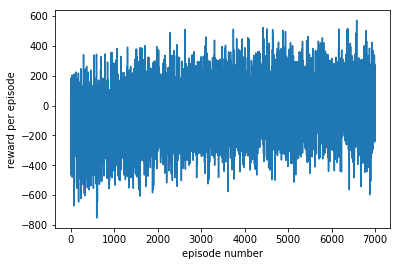

In [21]:
# plot results
with open('saved_pickle_files/rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

# save plots in saved_plots/ directory
plt.savefig('rewards.png')

print("Average reward of first 100 episodes is {0}".format(np.mean(rewards_per_episode[:100]))) 
print("Average reward of middle 100 episodes is {0}".format(np.mean(rewards_per_episode[3450:3550]))) 
print("Average reward of last 100 episodes is {0}".format(np.mean(rewards_per_episode[-100:]))) 

### Part - 2

In [37]:
a=0
b=100
avg_rewards_per_100_episodes = []
while b<=len(rewards_per_episode):
    avg_rewards = np.mean(rewards_per_episode[a:b])
    avg_rewards_per_100_episodes.append(avg_rewards)
    a+=100
    b+=100

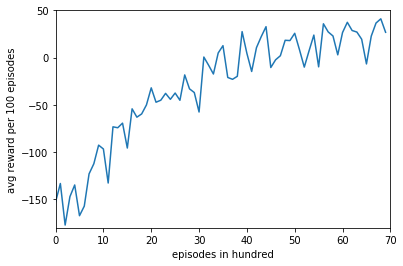

In [39]:
plt.plot(list(range(len(avg_rewards_per_100_episodes))), avg_rewards_per_100_episodes)
plt.xlabel("episodes in hundred")
plt.ylabel("avg reward per 100 episodes")
plt.axis([0, 70, -180, 50])
# save plots in saved_plots/ directory
plt.savefig('avg_rewards_per_100_episodes.png')

#### Epsilon-decay function used - 

In [11]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0005*i))

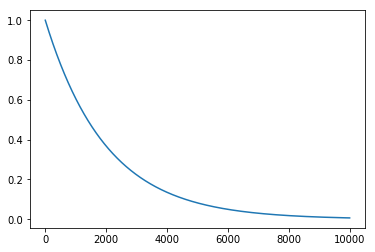

In [12]:
plt.plot(time, epsilon)
plt.show()

## Evaluating the Model (for Upgrad) - 

In [10]:
from keras.models import model_from_json

In [11]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
#loaded_model.compile(loss='rms', optimizer='Adam', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))